# Anomaly detection in energy storage systems.

# Overview

Renewable energy sources have become one of the significant factors contributing to new energy generation construction.

One of the critical components of renewables is Energy Storage Systems that conserve energy during peak production hours and release it when energy generation is limited. This helps to solve the problem of stability of energy generation from renewable sources of energy.

Safety is a critical question for Energy storage systems. Failure of one cell leads to a thermal runaway that results in the unstoppable chemical fire inside Energy Storage System that results in complete site destruction. https://www.spglobal.com/marketintelligence/en/news-insights/latest-news-headlines/burning-concern-energy-storage-industry-battles-battery-fires-51900636

While system failure can't be predicted because it depends on many factors, including cell internal structure damages, some factors contribute to it.

Some of them:

- Avoiding over-discharge and overcharge of batteries

- Control of cell temperature.

One of the challenges is that the Energy Storage system consists of hundreds of thousands of cells, each with a temperature and voltage sensor that generates enormous information. For example, https://pv-magazine-usa.com/2022/02/15/mce-approves-100mw-solar-plus-storage-project-in-california/ This project capacity is 75MWh It will require installation of at least 190 000 battery cells (up to 500 000 depending on the technology that will be used) each of them will provide information about their status.



# Business Understanding
My Stakeholder is one of the leading Energy Storage System manufacturers interested in increasing the reliability of their system. In addition, they want to decrease the time that engineers spend on-site during commissioning works. Therefore, stakeholder intends to have a model that can analyze the status of 10 000+ cells during commissioning and annual service works. 

This model should identify abnormal behavior of cells that can lead to hazards during further operations.

Abnormal behavior:

Too low/high voltage sensors readings.

Too low/high-temperature sensor readings

Current imbalance during charge/discharge.

Our model should accept raw data provided from BMS(Battery management system) systems manufactured by BMester (one of the key suppliers).

The model should be easy to use and to interpret results by commissioning engineers.

# Data

1) Sensor readings are taken from 5 cluster systems in June 2021 during commissioning works.


# Metrics
#### Our project will answer following question:
Can we forecast sensor readings limits and automatically identify cells that are out of limits for further investigation. 

#### Hypothesis:
H0 - Anomaly in cell

HA - There is statistically significant proof that there is no anomaly in the cell.

#### TP, TN, FP, FN definition

TP - We predicted anomaly, and it does exist

TN - We predicted that there is no anomaly and it doesn't exist

FP - We predicted an anomaly, but there was no anomaly.

FN - We predicted that there is no anomaly,  but it existed.


#### Metrics used  
To compare models, we will focus on two primary metrics:

Recall - Missing any anomaly case can lead to Hazard. Therefore, we are focused on finding as much as possible.

Accuracy - how well we can predict TP and TN. These are general metrics that will show model performance.

##### While it is impossible to say that the actual identified case will lead to Hazard, it is crucial to find and mark cells for further investigation of service engineers.





# Data Understanding
#### Sources of data:
1) Explore data folder: 2 cluster systems with several hours of data readings.

2) Test data: 5 cluster systems consist of 1200 voltage sensors, 1200 temperature sensors, and 5 current sensors.

Test data covers the period - 8h on the 10-11 June 2021, with temperature readings every 30 seconds voltage readings every 10 seconds.

Data was artificially modified to add anomaly cells. 



Inside the data folder, we have the following structure:
"cluster_n" - number of the cluster for N cluster system

Inside each cluster folder:

- temperature 

- total state

- voltage

Folders that contain reading for each sensor based on sensor type. 
Sensor readings are provided in CSV files; each file contains reading for 1 hour with different discrepancies depending on sensor type.


![Data](img/folder_structure.png)

# Data Cleaning
### Importing required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import re

%matplotlib inline


# Work with data
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


#Modeling
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from datetime import timedelta, datetime


#Other
import pickle
import time
import os, shutil 
import itertools
from docx import Document
from docx.shared import Inches
import statsmodels.api as sm
import zipfile
import os

# from warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
# simplefilter(action='ignore', category= FutureWarning)
# simplefilter(action='ignore', category= ConvergenceWarning)
# simplefilter(action='ignore', category= FitFailedWarning)
# simplefilter(action='ignore', category= UserWarning)

In [2]:
# config file. Thresholds can be adjusted in this file. 
# Voltage - in mV. 1V = 1000mV. Temperature in 1/10c. 10 = 1 degree C
# n_std - number of standard deviations
# Resample is how many seconds in single time series step. Can be adjusted to reduce granularity and increase processing speed. 
class config:
    def __init__(self):
        self.low_voltage_th = -3
        self.low_voltage_alarm = -2
        self.high_voltage_th = 3
        self.high_voltage_alarm = 2
        self.low_temperature = 100
        self.high_temperature = 100
        self.high_mean_temperature_alarm = 400
        self.low_mean_temperature_alarm = 50
        self.low_voltage_n_std = 3
        self.low_voltage_alarm_n_std = 2
        self.high_voltage_n_std = 3
        self.high_voltage_alarm_n_std = 2
        self.sensor_v_prec = 5
        self.period_h = 12
        self.markers = ["*", "<", "v","^","p",">","s","p","o", "*", "<", "v","^","p",">","s","p" ]
        self.cmap = plt.get_cmap('Dark2')
        self.resample = "30S"
        self.report_path = "report/"


conf = config()
# Set visual style - White backgound with a grid. 
sns.set_style("whitegrid")


##### Preprocessing functions
These functions are used to gather data and prepare them for further investigations.

In [131]:
# Function to:
# a) Combine all csv files inside the directory into one dataframe.
# b) Create time series
# c) Resample time series and remove missing data
# By default function consider that it is voltage sensor readings. Can be adjusted - df_type
# Function return preprocessed dataframe from several files.  

def create_dataframe(list_paths, df_type = "voltage"):
    """
    Input: paths of files that should be joined, type of sensors
    Output: Dataframe that contains preprocessed dataframe with resampled time.
    """
    
    # Make list of paths for all files inside dir
    files = [list_paths + file for file in os.listdir(list_paths) if file.endswith("csv")]
    #Lower case of df type to exclude mistakes due to capitalizations    
    df_type = df_type.lower()
    # Read CSV files
    dataframe = [pd.read_csv(file) for file in files]
    # Make final dataframe
    final_df = pd.concat(dataframe, axis = 0)
    # Convert to time series and set it as the index of the file
    final_df["MCGS_TIME"] = pd.to_datetime(final_df["MCGS_TIME"])
    final_df = final_df.set_index("MCGS_TIME")
    # Regular expressions to find columns that we don't need.
    reg = re.compile(df_type)
    drop_columns = [column for column in final_df.columns.str.lower() if not bool(re.match(reg, column))]
    # Finall preprocessing: 
    # -Convers columns to lowercase
    # -Drop unused columns
    # -Resample
    final_df.columns = final_df.columns.str.lower()
    final_df= final_df.drop(drop_columns, axis = 1)
    final_df = final_df.resample(conf.resample).mean().bfill()
    return final_df



In [4]:
# Combined preprocessing function

def data_preprocess(raw_folder):
    
     """
    Input: Data folder
    Output: List of dataframes that contains all data for each cluster. Each record is one cluster. 
    Function adjust itself based on the number of clusters
    """
    
    # Find clusters
    clusters = [cluster for cluster in sorted(os.listdir(raw_folder)) if "cluster" in cluster]
    conf.clusters = len(clusters)
    # Prepare path for each cluster
    clusters_paths = [(raw_folder + cluster + "/", cluster) for cluster in clusters]
    
    # Divide it cluster to different types of data will be used
    voltage_paths = [(cluster_parth[0]+"voltage/", cluster_parth[1]) for cluster_parth in clusters_paths]
    temperature_paths = [(cluster_parth[0]+"temperature/", cluster_parth[1]) for cluster_parth in clusters_paths]
    state_paths = [(cluster_parth[0]+"total state/", cluster_parth[1]) for cluster_parth in clusters_paths]

    # Create dataframes for each clusters
    df_voltage_list = [create_dataframe(voltage_path[0], "[a-zA-Z0-9_]+voltage") for voltage_path in voltage_paths]
    df_temperature_list = [create_dataframe(temperature_path[0], '[a-zA-Z0-9_]+temperature') for temperature_path in temperature_paths]
    df_state_list = [create_dataframe(state_path[0], '[a-zA-Z0-9_]+current$') for state_path in state_paths]

    # Check that all datasets in clusters
    assert len(df_voltage_list) == len(df_temperature_list), "The number of files with voltage readings doesn't match the number of files with temperature readings"
    assert len(df_voltage_list) == len(df_state_list), "The number of files with voltage readings doesn't match the number of files with current readings"

    # Check that same timeframes
    for i in range(len(df_voltage_list)):
        assert all(df_voltage_list[i].index == df_temperature_list[i].index), "Time series of voltage and temperature doesn't match"
        assert all(df_voltage_list[i].index == df_state_list[i].index), "Time series of voltage and current doesn't match"
    

    result_list = []
    # Get finall dataframe
    for i in range(len(df_voltage_list)):
        final = pd.concat([df_voltage_list[i], df_temperature_list[i], df_state_list[i]], axis = 1).dropna()
        result_list.append(final)
    print(f"Number of Clusters were found: {len(result_list)}")
    return result_list

# Function to find columns corresponding to different type of sensors
def find_columns(df):
    """
    Input: Dataframe
    Output: 3 lists of column names. Each list consist of column names of appropriate type - voltage, temperature, current
    """
    voltage_columns = [column for column in df.columns if bool(re.match(re.compile("[a-zA-Z0-9_]+voltage"), column))]
    temperatrue_columns = [column for column in df.columns if bool(re.match(re.compile('[a-zA-Z0-9_]+temperature'), column))]
    state_column = [column for column in df.columns if bool(re.match(re.compile('[a-zA-Z0-9_]+current$'), column))]
    return voltage_columns, temperatrue_columns, state_column
    
    

##### Data exploration functions.
Functions that will be required to explore the raw data

In [5]:
# Check distribution of sensor readings. We use histogram for visual inspection.
def check_distribution(df, moment, measure_type = "voltage"):
    """
    Input: Dataframe, the moment of time from Time series, type of sensors(for appropriate naming)
    Output: Show histogram of cells voltage/temperature values.
    """
    
    if measure_type == "voltage":
        print(f"Value mean : {round(np.mean(df.loc[moment,:]/1000),2)} V")
        print(f"Value standard deviation : {round(np.std(df.loc[moment,:]/1000),4)} V")
    elif measure_type == "temp":
        print(f"Value mean : {round(np.mean(df.loc[moment,:]/10),2)} C")
        print(f"Value standard deviation : {round(np.std(df.loc[moment,:]/10),4)} C")
    df.loc[moment,:].hist(bins = 10)
    plt.title("Values distribution chart")
    plt.xlabel("Investigated value")
    plt.ylabel("N of observations")
    plt.show()
    


##### Data analysis functions
They will be used to analyze preprocessed data

In [6]:
# Function to calculate decision boundaries

def create_thresholds(df_sensor_reading, std = True):
    """
    Input: Dataframe, containing sensor reading, type of decision boundaries(standard deviation or fixed number)
    Output: Dataframe with mean value, upper and lower al values(alarm values can be used for 1st type of alarms)
    upper and lower boundaries. 
    """
    
    # Calculate mean value and high/low thresholds.
    df_threshold = pd.DataFrame()
    # if calculated based on standard deviation
    if std == True:
        df_threshold["mean"] = np.mean(df_sensor_reading, axis = 1)
        df_threshold["lower_al"] = df_threshold["mean"] - conf.low_voltage_alarm_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        df_threshold["lower"] = df_threshold["mean"] - conf.low_voltage_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        df_threshold["upper_al"] = df_threshold["mean"] + conf.high_voltage_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        df_threshold["upper"] = df_threshold["mean"] + conf.high_voltage_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        # Apply sensors precision from sensor documentation.
        df_threshold["upper"][df_threshold["upper"] - df_threshold["mean"] < conf.sensor_v_prec] = df_threshold["mean"] + conf.sensor_v_prec
        df_threshold["lower"][df_threshold["lower"] - df_threshold["mean"] > -conf.sensor_v_prec] = df_threshold["mean"] - conf.sensor_v_prec
        df_threshold["upper_al"][df_threshold["upper_al"] - df_threshold["mean"] < conf.sensor_v_prec] = df_threshold["mean"] + conf.sensor_v_prec
        df_threshold["lower_al"][df_threshold["lower_al"] - df_threshold["mean"] > -conf.sensor_v_prec] = df_threshold["mean"] - conf.sensor_v_prec
    else: 
        # Fixed thresholds. Don't need sensor precision
        df_threshold["mean"] = np.mean(df_sensor_reading, axis = 1)
        df_threshold["lower_al"] = df_threshold["mean"] - conf.low_temperature
        df_threshold["lower"] = df_threshold["mean"] - conf.low_temperature
        df_threshold["upper_al"] = df_threshold["mean"] + conf.high_temperature
        df_threshold["upper"] = df_threshold["mean"] + conf.high_temperature      
    return df_threshold



# Function to find anomalies
def find_anomaly(dataframe, thresholds, current_df, voltage = True):
    """
    Input: Dataframe, Dataframe with decision boundaries, dataframe with voltage readings, type of data.
    Output: sensor anomalies(cluster, type of anomaly, sensor) and a full report containing the time of alarm
    """
    
    
    # Identify anomalies based on thresholds.
    sensor_report_full = []
    sensor_anomaly_names=[]
    
    for sensor in list(dataframe.columns):
        # Logic of finidng anomalies
        if voltage == True:
            xz = [re.search('([a-z0-9]+_current)', columns).group(1)for columns in current_df.columns][0]
            anomaly = dataframe[sensor][(dataframe[sensor] < thresholds["lower"]) & (current_df[xz] >200)] 
        else:
            anomaly = dataframe[sensor][(thresholds["mean"] > conf.high_mean_temperature_alarm) | 
                                      (thresholds["mean"] < conf.low_mean_temperature_alarm) |
                                      (dataframe[sensor] < thresholds["lower"]) | 
                                      (dataframe[sensor] > thresholds["upper"])]
        # Find type of anomaly
        if len(anomaly) > 0:
            sensor_name = anomaly.name
            if voltage == True:
                stage = "discharge anomaly"
            else:
                stage = "temperature anomaly"
            sensor_report_full.append((anomaly, sensor_name, stage))
            sensor_anomaly_names.append(sensor_name)
    # print(sensor_list) #Debugging feature
    return sensor_anomaly_names, sensor_report_full

# Combine faulty sensors data into one list. 
# !!!! Will be removed in next version
def combine_faults(fault_list, sensors):
    """
    Function marked to be removed
    """
    [fault_list.append((sensor[0], sensor[1], sensor[2])) for sensor in sensors]
    return fault_list

# Easy readable representation on results
def print_results(fault_list, full_report = False):
    """
    Input: The List of anomalies from find_anomaly function
    Output: print results in an easy readable form
    """
    
    # Full report is needed to see the time of alarm.
    # Repeat for each cluster
    for sensor in fault_list:
        # Find cluster number, sensor type and number
        cluster = re.search('cluster_([0-9]+)_', sensor[1]).group(1)
        sensor_type = re.search('cluster_.+_([A-Za-z]+)_', sensor[1]).group(1)
        sensor_n= re.search('cluster_.+_[A-Za-z_]+_([0-9]+)$', sensor[1]).group(1)
        type_alarm = sensor[2]
        # This one can be used for full report
        alarm_time = sensor[0].keys()
        print(f"cluster N {cluster}, {type_alarm}, {sensor_type} sensor N {sensor_n}")
        if full_report == True:
            print(alarm_time)

    

##### Data visualization functions

In [7]:
# Function to plot middle value and decision boundaries of sensors
def show_boundaries(dataframe,  thresholds, voltage = True):
    """
    Input: Dataframe, dataframe with boundaries, type of sensors
    Output: Figure(needed for create_report function)
    """
    
    
    fig, axs = plt.subplots(figsize = (20, 8))
    # Plot data predictions boundaries
    plt.plot(thresholds["mean"], label='mean value', c = "black")
    if voltage == True:
        plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")
    else:
        plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "+-10 degrees range")

    # Plot the range for confidence intervals
    plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.15)
    date_form = DateFormatter("%b%d-%H:%M:%S")
    axs.xaxis.set_major_formatter(date_form)
    if voltage == True:
        plt.ylim(2600,3600)
    #plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
    if voltage == True:
        axs.set_title("Voltage vs time plot")
        axs.set_ylabel("Voltage, mV")
    else:
        axs.set_title("Temperature vs time plot")
        axs.set_ylabel("Temperature, 1/10 degrees C")
    axs.set_xlabel("Time, Day/H/M")
    plt.legend()
    plt.show() 
    return fig

# Function to plot all sensors and decision boundaries(can be removed)    
def plot_sensors(df, voltage = True, boundaries = False):
    """
    Input: Dataframe, type of sensors, should be decision boundaries be plotted
    Output: Figure(needed for create_report function)
    """
    
    # Create figure
    fig, axs = plt.subplots(figsize = (15, 6))
    # Plot sensors
    axs.plot(df)
    
    # Plot boundaries
    if boundaries == True:
        # Calculate boundaries
        if "temperature" in str(df.columns):
            thresholds = create_thresholds(df, std = False)
        else:
            thresholds = create_thresholds(df, std = True)
        # Draw boundaries
        if voltage == True:
            plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")
            plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.05)
        else:
            plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "+-10 degrees range")
            plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.05)
    # Format data
    date_form = DateFormatter("%b%d-%H:%M:%S")
    axs.xaxis.set_major_formatter(date_form)    
    
    if voltage:
        axs.set_title("Cell voltage vs time")
        plt.ylim(2600,3700)
        axs.set_ylabel("Voltage, mV")
    else:
        axs.set_title("Cell temperature vs time")
        axs.set_ylabel("Temperature, 1/10 degrees C")
    axs.set_xlabel("Time, Day/H/M")
    #plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
    plt.show()
    return fig
    
# Function to plot faulty sensors and decision boundaries(can be removed)
    
def show_sensors(dataframe, faulty_sensors):
     """
    Input: Dataframe,list of anomaly sensors (from find anomaly)
    Output: Figure(needed for create_report function)
    """
    
    fig, axs = plt.subplots(figsize = (20, 8))
    # Calculate boundaries
    if "temperature" in str(dataframe.columns):
        thresholds = create_thresholds(dataframe, std = False)
    else:
        thresholds = create_thresholds(dataframe, std = True)
    
    # Plot data predictions boundaries
    plt.plot(thresholds["mean"], label='mean voltage', c = "black")
    [plt.plot(dataframe[sensor[1]], label = sensor[1], color = conf.cmap(number)) for number, sensor in enumerate(faulty_sensors)]
    [plt.plot(sensor[0], label = "alarm " + sensor[1], c = "red", marker = conf.markers[number],markersize = 8, linestyle="") for number, sensor in enumerate(faulty_sensors)]

    plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")

    # Plot the range for confidence intervals
    plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.15)
    date_form = DateFormatter("%b%d-%H:%M:%S")
    axs.xaxis.set_major_formatter(date_form)
    # plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
    # axs.set_title("Voltage vs time plot")
    axs.set_xlabel("Time, Day/H/M")
    if "temperature" in str(dataframe.columns):
        axs.set_ylabel("Temperature, 1/10 degrees C")
        axs.set_title("Cell temperature vs time")
    else:
        axs.set_ylabel("Voltage, mV")
        plt.ylim(2600,3600)
        axs.set_title("Cell voltage vs time")

    plt.legend()
    plt.show()
    return fig

##### High level functions: cluster level
  

In [8]:
# Function to analyze data and find sensors out of boundaries

def analyse_data(data):
    """
    Input: List of dataframes from data_preprocess function
    Output: list of all sensors with anomalies for all clusters
    """
    # Prepare empty list
    faulty_sensors = []
    for result in data:
    # For each cluster
        # Create columns
        voltage_columns, temperatrue_columns, state_column = find_columns(result)
        # Create voltage, temperature, state dataframes
        df_volt = result[voltage_columns]
        df_temp = result[temperatrue_columns]
        df_state = result[state_column]
        # Create thresholds
        voltage_thresholds = create_thresholds(df_volt)
        temperature_thresholds =  create_thresholds(df_temp, False)
        # Find anomalies
        sensor_volt_names , sensors_volt = find_anomaly(df_volt, voltage_thresholds, df_state)
        sensor_temp_names, sensors_temp = find_anomaly(df_temp, temperature_thresholds, df_state, False)
        # Add results into the list
        combine_faults(faulty_sensors, sensors_volt)
        combine_faults(faulty_sensors, sensors_temp)
    return faulty_sensors




In [9]:
# Function to plot all temperature and voltage sensors within cluster
def plot_cluster_sensors(data, cluster, boundaries = False):
    """
    Input: List of dataframes from data_preprocess function, cluster number, do we need to show decision boundaries
    Output: plots of temperature and voltage sensors in the required cluster
    """
    
    # Check that cluster exist
    assert cluster <= len(data), "No such cluster in data"
    assert cluster > 0, "Cluster N cannot be zero or negative"
    # Get cluster data
    cluster = cluster - 1
    cluster_data = data[cluster]
    # Prepare data
    voltage_columns, temperatrue_columns, state_column = find_columns(cluster_data)
    # Plot voltage and temperature sensors data.
    # Decision boundaries visualization can be turned off (see boundaries value, by default = turned off).
    fig_v = plot_sensors(cluster_data[voltage_columns], True, boundaries)
    fig_t = plot_sensors(cluster_data[temperatrue_columns], False, boundaries)
    cluster_n = cluster + 1
    title_voltage = "report/Cluster " + str(cluster_n) + " voltage sensors.png"
    title_temp = "report/Cluster " + str(cluster_n) + " temperature sensors.png"
    fig_v.savefig(title_voltage)
    fig_t.savefig(title_temp)
    
# Function to plot all anomaly sensors within cluster
def plot_cluster_anomalies(data,faulty_sensors, cluster):
    
    """
    Input: List of dataframes from data_preprocess function, list of sensors with anomalies, cluster number
    Output: plots of anomaly sensors in the required cluster
    """
        
    # Check that cluster exist
    assert cluster <= len(data), "No such cluster in data"
    assert cluster > 0, "Cluster N cannot be zero or negative"  
    # Show number of clusters in system.
    print(f"Cluster N : {cluster}")
    # Filter only sensors for required cluster
    all_sensors= [sensor for sensor in faulty_sensors if re.search('cluster_([0-9]*)_[A-Za-z_]+', sensor[1]).group(1) == str(cluster)] 
    cluster = cluster - 1
    # Divide into 2 classes
    voltage_sensors = [sensor for sensor in all_sensors if "voltage" in str(sensor[1])]
    temperature_sensors = [sensor for sensor in all_sensors if "temperature" in str(sensor[1])]
    # Show number of anomaly sensors
    n_voltage_sensors = len(voltage_sensors)
    n_temperature_sensors = len(temperature_sensors)
    print(f'The number of sensors with voltage anomaly: {n_voltage_sensors}')
    print(f'The number of sensors with temperature anomaly: {n_temperature_sensors}')
    # Data preparation for visualisation
    data = data[cluster]
    voltage_columns, temperatrue_columns, state_column = find_columns(data)
    # Sensors visualisation
    cluster_n = cluster + 1
    if n_voltage_sensors >= 0:
            fig_v = show_sensors(data[voltage_columns], voltage_sensors)
            title_voltage = "report/Cluster " + str(cluster_n) + " voltage anomaly sensors.png"
            fig_v.savefig(title_voltage)
    if n_voltage_sensors >= 0:
            fig_t = show_sensors(data[temperatrue_columns], temperature_sensors)
            title_temp = "report/Cluster " + str(cluster_n) + " temperature anomaly sensors.png"
            fig_t.savefig(title_temp)

    

In [65]:
# Function to get all results (needed to be run before creating report)
def get_all_results(data, faulty_sensors, boundaries = True):
    
    """
    Input: List of dataframes from data_preprocess function, list of sensors with anomalies
    Output: Create sensor and anomalies plots for each sensor.  
    """
    
    for i in range(1, conf.clusters +1):
        # For each cluster make sensors plots and anomalies plots.
        plot_cluster_sensors(data, i, True)
        plot_cluster_anomalies(data,faulty_sensors, i)

# Function to make a doc file with full report.  
def create_report(faulty_sensors):
    
    """
    Input: Sensors with anomalies
    Output: Create Word file report.  
    https://python-docx.readthedocs.io/en/latest/ was used. 
    """
    
    document = Document()
    heading = "Report:" + str(conf.clusters)+ " cluster system report." + " \n Time: " + datetime.now().strftime("%D - %H:%M")
    document.add_heading(heading, 0)
    p = document.add_paragraph('This system consist of ')
    p.add_run(str(cluster)).bold = True
    p.add_run(' clusters.')
    p = document.add_paragraph('Total number of anomalies ')
    p.add_run(str(len(faulty_sensors))).bold = True
    p.add_run(' .')
    document.add_heading('Error overview:', level=1)
    table = document.add_table(rows=1, cols=5)
    hdr_cells = table.rows[0].cells
    hdr_cells[0].text = 'Cluster N'
    hdr_cells[1].text = 'Sensor N'
    hdr_cells[2].text = 'Alarm type'
    hdr_cells[3].text = 'Error begin time:'
    hdr_cells[4].text = 'Error end time:'
    for sensor in faulty_sensors:
        row_cells = table.add_row().cells
        row_cells[0].text = re.search('cluster_([0-9]+)_', sensor[1]).group(1)
        row_cells[1].text = re.search('cluster_.+_[A-Za-z_]+_([0-9]+)$', sensor[1]).group(1)
        row_cells[2].text = sensor[2]
        row_cells[3].text = str(sensor[0].index[0])
        row_cells[4].text = str(sensor[0].index[-1])
    document.add_page_break()
    files = [conf.report_path + file for file in os.listdir(conf.report_path) if (file.endswith("png")) and (file.startswith("Cluster"))]
    for i in list(range(conf.clusters)):
        i = i + 1
        heading = 'Error overview: '  + "Cluster " + str(i) + " ."
        document.add_heading(heading, level=1)
        p = document.add_paragraph('This cluster has: ')
        p.add_run(str(len([sensor for sensor in faulty_sensors if 
                     (re.search('cluster_([0-9]+)_', sensor[1]).group(1) == str(i)) and
                     sensor[2] == 'discharge anomaly']))).bold = True
        p.add_run( " voltage anomalies.\n")
        p = document.add_paragraph('This cluster has: ')
        p.add_run(str(len([sensor for sensor in faulty_sensors if 
                     (re.search('cluster_([0-9]+)_', sensor[1]).group(1) == str(i)) and
                     sensor[2] == "temperature anomaly"]))).bold = True
        p.add_run( " temperature anomalies.\n")
        heading = 'Voltage and Temperature plots over time'
        document.add_heading(heading, level=2)
        document.add_paragraph('Voltage sensor readings: ')
        for file in files:
            if str(i) in file and "voltage sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass
        document.add_paragraph('Temperature sensor readings: ')
        for file in files:
            if str(i) in file and "temperature sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass
        document.add_page_break()
        heading = "Voltage and Temperature anomalies plots over time"
        document.add_heading(heading, level=2)
        document.add_paragraph('Voltage anomalies: ')
        for file in files:
            if str(i) in file and "voltage anomaly sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass         
        document.add_paragraph('Temperature sensor readings: ')
        for file in files:
            if str(i) in file and "temperature anomaly sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass
        document.add_page_break()
    document.save('report/report_file.docx')


    
    
        

# Model performance investigation.

## I) Small dataset
Because the number of sensors can be very big, we will start investigations with a small datasets.
First we will investigate different models performance on a small dataset, to choose the best model.

In [10]:
# Prepare data.
raw_folder = "explore/"
result_list = data_preprocess(raw_folder)

Number of Clusters were found: 2


In [11]:
# find cell voltage, temperature, state columns
voltage_columns, temperatrue_columns, state_column = find_columns(result_list[0])


In [12]:
# Check first cluster information. 
result_list[0].head()

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240,cluster1_current
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:00:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:01:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:01:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:02:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0


### Descriptive statistics

##### Temperature:

In [115]:
result_list[0][temperatrue_columns].head()

,cluster_1_temperature_001,cluster_1_temperature_002,cluster_1_temperature_003,cluster_1_temperature_004,cluster_1_temperature_005,cluster_1_temperature_006,cluster_1_temperature_007,cluster_1_temperature_008,cluster_1_temperature_009,cluster_1_temperature_010,...,cluster_1_temperature_231,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 20:00:00,282.0,276.0,275.0,275.0,277.0,279.0,281.0,277.0,276.0,279.0,...,278.0,271.0,276.0,280.0,278.0,277.0,273.0,274.0,275.0,275.0
2021-06-10 20:00:30,282.0,277.0,276.0,276.0,278.0,280.0,282.0,278.0,277.0,280.0,...,279.0,272.0,276.0,280.0,279.0,277.0,273.0,275.0,276.0,275.0
2021-06-10 20:01:00,283.0,278.0,276.0,276.0,278.0,281.0,282.0,279.0,278.0,280.0,...,280.0,273.0,277.0,281.0,279.0,278.0,274.0,276.0,276.0,276.0
2021-06-10 20:01:30,284.0,279.0,277.0,277.0,279.0,281.0,283.0,279.0,279.0,281.0,...,280.0,274.0,278.0,281.0,280.0,278.0,275.0,276.0,277.0,276.0
2021-06-10 20:02:00,284.0,279.0,278.0,278.0,280.0,282.0,284.0,280.0,279.0,282.0,...,281.0,274.0,279.0,282.0,281.0,279.0,276.0,277.0,278.0,277.0


In [116]:
result_list[0][temperatrue_columns].describe()

,cluster_1_temperature_001,cluster_1_temperature_002,cluster_1_temperature_003,cluster_1_temperature_004,cluster_1_temperature_005,cluster_1_temperature_006,cluster_1_temperature_007,cluster_1_temperature_008,cluster_1_temperature_009,cluster_1_temperature_010,...,cluster_1_temperature_231,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.00000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,283.262963,272.700000,262.066667,262.460185,276.310185,293.860185,298.848148,293.602778,298.968519,306.575926,...,305.585185,295.499074,292.975000,296.621296,289.92963,280.939815,270.125926,262.690741,268.470370,277.055556
std,32.625054,31.571576,30.670106,31.052323,33.266262,36.391343,35.230409,32.021607,33.287371,37.913171,...,38.278020,33.393406,32.630153,36.930816,36.37347,34.955010,32.357922,30.985373,31.761873,32.465518
min,232.000000,224.000000,216.000000,215.000000,225.000000,235.000000,240.000000,240.000000,243.000000,243.000000,...,243.000000,241.000000,240.000000,237.000000,232.00000,227.000000,219.000000,215.000000,219.000000,225.000000
25%,257.000000,245.000000,233.000000,233.000000,247.000000,263.000000,273.000000,273.000000,277.000000,279.000000,...,280.000000,275.000000,272.000000,269.000000,261.00000,251.000000,241.000000,234.000000,240.000000,251.000000
50%,288.000000,279.000000,266.000000,266.000000,283.000000,298.000000,301.000000,296.000000,299.000000,306.000000,...,305.000000,295.000000,295.000000,298.500000,294.00000,286.000000,276.000000,266.000000,273.000000,281.000000
75%,312.000000,301.000000,290.000000,291.000000,307.000000,323.000000,327.000000,318.250000,326.000000,338.000000,...,334.000000,320.250000,319.000000,325.000000,318.00000,311.000000,299.000000,292.000000,297.000000,305.000000
max,346.000000,331.000000,316.000000,317.000000,334.000000,359.000000,363.000000,353.000000,359.000000,375.000000,...,380.000000,359.000000,352.000000,364.000000,357.00000,343.000000,326.000000,316.000000,327.000000,339.000000


In [123]:
# Check for missing values
result_list[0][temperatrue_columns].isna().sum().sum()

0

In [124]:
result_list[0][temperatrue_columns].shape
print(f"The number of records {result_list[0][temperatrue_columns].shape[0]}")
print(f"The number of sensors {result_list[0][temperatrue_columns].shape[1]}")

The number of records 1080
The number of sensors 240


Every cell has a temperature within 200-400. It is reported in 1/10 degrees C. Based on industry standards average working temperature is 20-40 C.
There are 240 cells in the cluster.

##### Voltage

In [118]:
result_list[0][voltage_columns].head()

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_cellvoltage_231,cluster_1_cellvoltage_232,cluster_1_cellvoltage_233,cluster_1_cellvoltage_234,cluster_1_cellvoltage_235,cluster_1_cellvoltage_236,cluster_1_cellvoltage_237,cluster_1_cellvoltage_238,cluster_1_cellvoltage_239,cluster_1_cellvoltage_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 20:00:00,3389.666667,3391.666667,3389.000000,3396.333333,3393.333333,3389.000000,3391.000000,3385.333333,3390.666667,3390.0,...,3392.333333,3385.666667,3393.333333,3394.333333,3389.000000,3394.333333,3400.333333,3394.000000,3390.000000,3393.333333
2021-06-10 20:00:30,3391.000000,3392.666667,3390.000000,3397.666667,3394.000000,3389.666667,3392.000000,3386.333333,3391.333333,3391.0,...,3393.666667,3386.666667,3394.666667,3395.666667,3389.666667,3395.333333,3401.000000,3394.333333,3391.000000,3394.666667
2021-06-10 20:01:00,3391.333333,3393.333333,3390.666667,3398.000000,3395.000000,3391.000000,3392.333333,3387.333333,3392.333333,3392.0,...,3394.666667,3388.000000,3395.333333,3396.333333,3391.000000,3396.000000,3402.000000,3395.333333,3392.000000,3396.000000
2021-06-10 20:01:30,3392.666667,3394.000000,3391.666667,3399.333333,3396.000000,3391.666667,3393.666667,3388.333333,3393.000000,3393.0,...,3395.333333,3388.333333,3396.000000,3397.333333,3391.333333,3397.333333,3402.333333,3396.333333,3392.333333,3396.333333
2021-06-10 20:02:00,3393.000000,3395.000000,3392.666667,3400.000000,3397.000000,3392.666667,3394.000000,3389.000000,3394.000000,3394.0,...,3396.000000,3389.333333,3397.000000,3398.000000,3392.333333,3398.000000,3403.333333,3397.000000,3393.666667,3397.333333


In [119]:
result_list[0][voltage_columns].describe()

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_cellvoltage_231,cluster_1_cellvoltage_232,cluster_1_cellvoltage_233,cluster_1_cellvoltage_234,cluster_1_cellvoltage_235,cluster_1_cellvoltage_236,cluster_1_cellvoltage_237,cluster_1_cellvoltage_238,cluster_1_cellvoltage_239,cluster_1_cellvoltage_240
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,3319.755556,3322.576235,3322.388580,3325.474383,3322.386420,3319.170988,3318.921296,3317.677469,3317.763580,3318.651852,...,3319.902469,3317.745988,3318.936420,3320.348457,3319.969444,3322.694753,3327.036728,3324.596605,3322.683025,3318.510494
std,114.624040,121.304436,121.573001,125.565303,121.091945,108.633136,109.598805,108.537527,105.573689,106.356950,...,105.013831,103.768530,109.032930,110.558642,108.450294,114.584893,123.520812,120.183806,115.329838,119.801180
min,2830.000000,2793.000000,2784.666667,2750.666667,2791.000000,2859.333333,2861.000000,2861.000000,2881.666667,2876.333333,...,2881.000000,2886.666667,2864.666667,2856.666667,2858.000000,2835.333333,2794.000000,2806.000000,2827.333333,2791.333333
25%,3314.916667,3317.916667,3316.750000,3317.500000,3316.500000,3313.500000,3313.750000,3312.750000,3311.500000,3312.583333,...,3314.500000,3311.500000,3314.500000,3315.916667,3313.916667,3317.250000,3319.750000,3318.833333,3316.000000,3315.916667
50%,3335.000000,3336.166667,3336.000000,3335.000000,3335.000000,3334.000000,3334.333333,3335.000000,3334.000000,3335.000000,...,3335.000000,3335.000000,3334.000000,3335.666667,3335.000000,3335.666667,3336.000000,3335.000000,3335.000000,3336.000000
75%,3373.083333,3386.250000,3384.833333,3397.750000,3386.666667,3365.250000,3365.000000,3361.000000,3359.333333,3361.000000,...,3363.750000,3357.333333,3365.083333,3368.583333,3366.333333,3379.083333,3400.416667,3391.333333,3380.083333,3373.666667
max,3572.333333,3596.666667,3595.333333,3589.000000,3576.333333,3553.666667,3548.333333,3541.000000,3539.666667,3533.333333,...,3541.333333,3525.000000,3556.000000,3554.000000,3550.666667,3569.000000,3591.000000,3595.000000,3584.000000,3571.000000


In [122]:
# Check for missing values
result_list[0][voltage_columns].isna().sum().sum()

0

In [120]:
# The number of sensors and readings
result_list[0][voltage_columns].shape
print(f"The number of records {result_list[0][voltage_columns].shape[0]}")
print(f"The number of sensors {result_list[0][voltage_columns].shape[1]}")

The number of records 1080
The number of sensors 240


Every cell has a voltage within 2500-3600. It is reported in mVC. Based on industry standards average working voltage of LFP cells 2.4-3.7 V or 2400-3600mV
There are 240 cells in the cluster.

## II) First model

In [13]:
# We will use SARIMAX model as a baseline. 
# Create 3 dataframe with voltage, current, temperature
df_30sec = result_list[0][voltage_columns]
df_30sec_cur = result_list[0][state_column]
df_30sec_temp = result_list[0][temperatrue_columns]


In [14]:
# Chech dataframe
print(df_30sec.shape)
df_30sec.head()

(360, 240)


,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_cellvoltage_231,cluster_1_cellvoltage_232,cluster_1_cellvoltage_233,cluster_1_cellvoltage_234,cluster_1_cellvoltage_235,cluster_1_cellvoltage_236,cluster_1_cellvoltage_237,cluster_1_cellvoltage_238,cluster_1_cellvoltage_239,cluster_1_cellvoltage_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:00:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:01:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:01:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:02:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0


In [15]:
# Convert to single series univariate model.
mean_30sec = np.mean(df_30sec, axis = 1)
# Check for stationary
adfuller(mean_30sec)[1]
# Data is not stationary

0.6476455750640476

<AxesSubplot:xlabel='MCGS_TIME'>

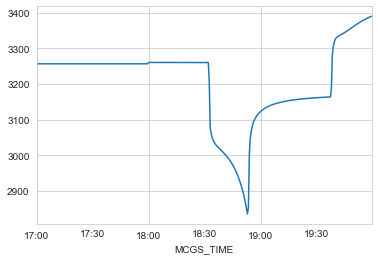

In [16]:
# Visulize data
mean_30sec.plot()

<AxesSubplot:xlabel='MCGS_TIME'>

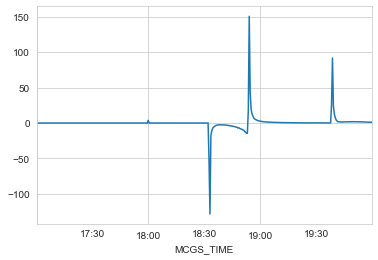

In [17]:
# Convert into stationary and check visual representation. 
roll_mean = mean_30sec.diff(periods=1).dropna()
roll_mean.plot()

In [18]:
# Check new time series for stationary
adfuller(roll_mean)[1]
# Data is stationary

4.883733815473972e-19

In [19]:
# We will use SARIMAX model with diff value 1.
model = sm.tsa.statespace.SARIMAX(mean_30sec, order = (2,1,1), enforce_invertibility=False)

In [20]:
# Fit the model and print results
result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81848D+00    |proj g|=  2.02297D-02

At iterate    5    f=  3.81832D+00    |proj g|=  4.60524D-03

At iterate   10    f=  3.81797D+00    |proj g|=  1.54741D-03

At iterate   15    f=  3.81796D+00    |proj g|=  1.47207D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   5.707D-06   3.818D+00
  F =   3.8179542275818146     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1374.464
Date:                Mon, 07 Mar 2022   AIC                           2756.927
Time:                        21:31:44   BIC                           2772.460
Sample:                    06-10-2021   HQIC                          2763.104
                         - 06-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0706      1.128      0.063      0.950      -2.141       2.282
ar.L2          0.1097      0.545      0.201      0.841      -0.959       1.179
ma.L1          0.4339      1.136      0.382      0.702      -1.792       2.660
sigma2       123.7931      2.053     60.305      0.000     119.770     127.817
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            140491.42
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             504.46   Skew:                             4.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        99.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
# We will get decision boundaries based on our predictions
pred = result.get_prediction(start = "2021-06-10 17:30:00", dynamic = False)
pred_conf = pred.conf_int(alpha=0.005)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Text(0.5, 0, 'Time, Day/H/M')

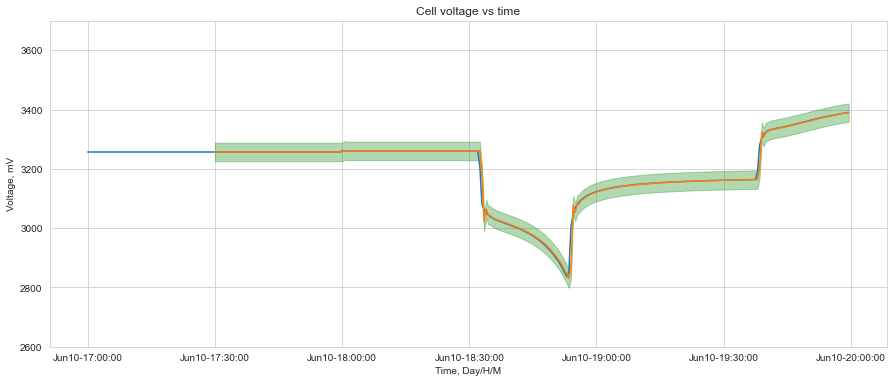

In [132]:
# Plot real vs predicted values along with confidence interval
fig, axs = plt.subplots(figsize = (15, 6))

# Plot observed values
plt.plot(mean_30sec, label='observed')

# Plot predicted values
plt.plot(pred.predicted_mean, label = "predicted")

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:,0],
                 pred_conf.iloc[:,1], color = "green", alpha = 0.3)
# Format data
date_form = DateFormatter("%b%d-%H:%M:%S")
axs.xaxis.set_major_formatter(date_form)    

axs.set_title("Cell voltage vs time")
plt.ylim(2600,3700)
axs.set_ylabel("Voltage, mV")
axs.set_xlabel("Time, Day/H/M")


Text(0.5, 0, 'Time')

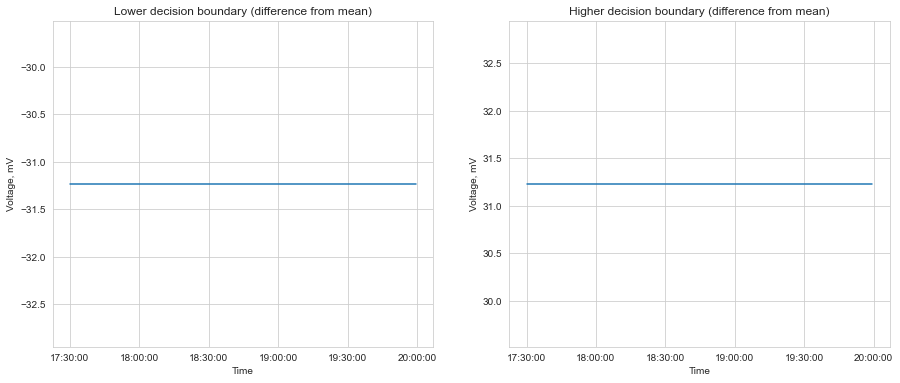

In [141]:
# plot prediction boundaries 
fig, axs = plt.subplots(1,2 , figsize = (15, 6))

axs[0].plot(pred.predicted_mean - pred_conf.iloc[:,1], label = "Lower boundary")
axs[1].plot(pred.predicted_mean - pred_conf.iloc[:,0], label = "Higher boundary")
date_form = DateFormatter("%H:%M:%S")
axs[0].xaxis.set_major_formatter(date_form)    
axs[0].set_title("Lower decision boundary (difference from mean)")
axs[0].set_ylabel("Voltage, mV")
axs[0].set_xlabel("Time")


axs[1].xaxis.set_major_formatter(date_form)    
axs[1].set_title("Higher decision boundary (difference from mean)")
axs[1].set_ylabel("Voltage, mV")
axs[1].set_xlabel("Time")

# Decision boundary is straight line over the time

In [24]:
# Lets find end of discharge point
timestamp_eod = [key for key, value in df_30sec.min(axis=1).items() if value == df_30sec.min(axis=1).min() ]
timestamp_eod

[Timestamp('2021-06-10 18:53:00', freq='30S')]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


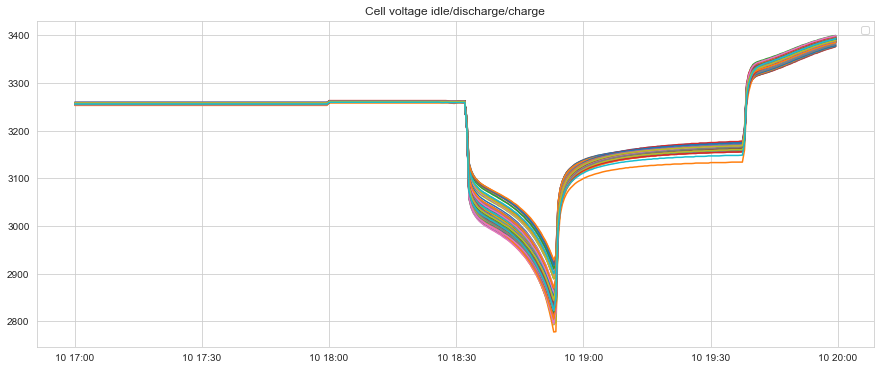

In [128]:
# Lets plot voltage distribution during time. 
fig, axs = plt.subplots(figsize = (15, 6))
plt.plot(df_30sec)
axs.set_title("Cell voltage idle/discharge/charge")
# plt.vlines(x = df_30sec.index[184],ymin = 2800, ymax = 3400, color = "red", label = "Start of discharge")
# plt.vlines(x = timestamp_eod,ymin = 2800, ymax = 3400, color = "blue", label = "EOD")
plt.legend()
plt.show()

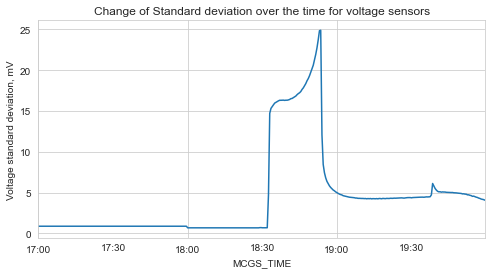

In [148]:
# Lets plot also standard deviation on sensor reading during the time.
fig, axs = plt.subplots(figsize = (8, 4))

date_form = DateFormatter("%H:%M:%S")
axs.xaxis.set_major_formatter(date_form)    
axs.set_title("Change of Standard deviation over the time for voltage sensors")
axs.set_ylabel("Voltage standard deviation, mV")
axs.set_xlabel("Time")
np.std(df_30sec, axis = 1).plot(ax=axs)

plt.show()

In [151]:
# Check for anomalies in sensors 
sensor_list = []
for sensor in list(df_30sec.columns):
    anomaly = df_30sec["2021-06-10 17:30:00":][sensor][(df_30sec["2021-06-10 17:30:00":][sensor] < pred_conf.iloc[:,0])] 
    if len(anomaly) > 0:
        sensor_name = anomaly.name
        sensor_list.append(sensor_name)

print(f"The number of anomaly sensors: {len(sensor_list)} from 240 observed sensors")



The number of anomaly sensors: 240 from 240 observed sensors


### Model gives us positive prediction 100% of the time.  Most of them false positives
##### The model can't be utilized


## Second model
### Voltage distribution


In [29]:
# We need to check voltage distribution in different time of discharge and charge. 

Value mean : 3.26 V
Value standard deviation : 0.0007 V


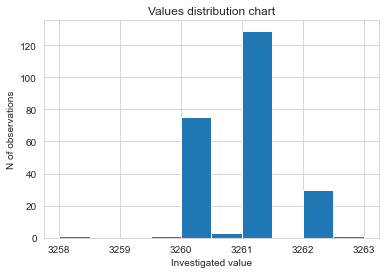

In [30]:
# Lets check voltage sensor reading distribution during different moments of time.
# idle
moment = '2021-06-10 18:00:00'
check_distribution(df_30sec, moment)

Value mean : 3.26 V
Value standard deviation : 0.0007 V


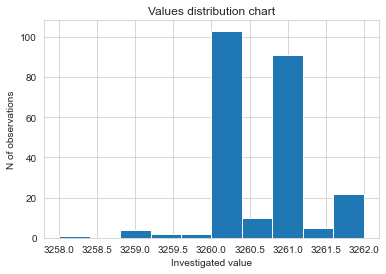

In [31]:
# Resting
moment = '2021-06-10 18:30:00'
check_distribution(df_30sec, moment)

Value mean : 3.16 V
Value standard deviation : 0.0044 V


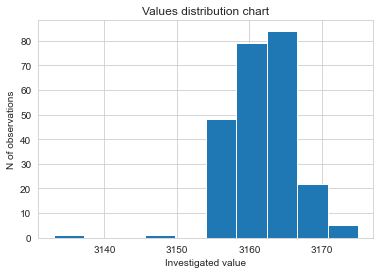

In [32]:
# Charging
moment = '2021-06-10 19:30:00'
check_distribution(df_30sec, moment)



Value mean : 3.04 V
Value standard deviation : 0.016 V


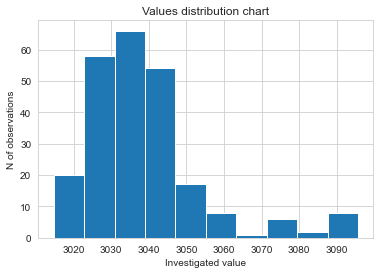

In [33]:
# Start of discharge
moment = '2021-06-10 18:35:00'
check_distribution(df_30sec, moment)


Value mean : 2.97 V
Value standard deviation : 0.0172 V


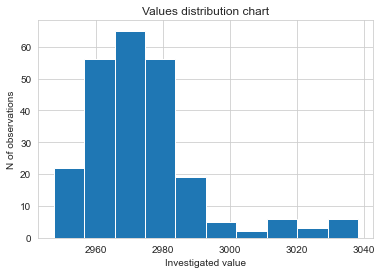

In [34]:
# Middle of discharge
moment = '2021-06-10 18:45:00'
check_distribution(df_30sec, moment)

In [35]:
# Lets find end of discharge point
timestamp_eod = [key for key, value in df_30sec.min(axis=1).items() if value == df_30sec.min(axis=1).min() ]
timestamp_eod

[Timestamp('2021-06-10 18:53:00', freq='30S')]

Value mean : 2.84 V
Value standard deviation : 0.0249 V


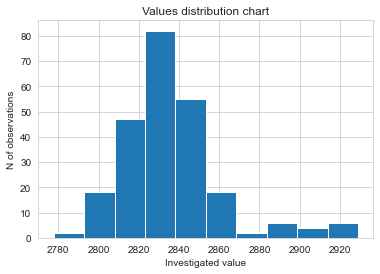

In [36]:
# End of discharge
moment = '2021-06-10 18:53:00'
check_distribution(df_30sec, moment)

##### As we can see voltage is normaly distributet around cells.
##### We will make normality assumption
Based on normality assumption we will mark cells with parameters that are more than 3 standard deviations away from the mean value - it correspond to 0.3 % cases. We will consider them as anomalies

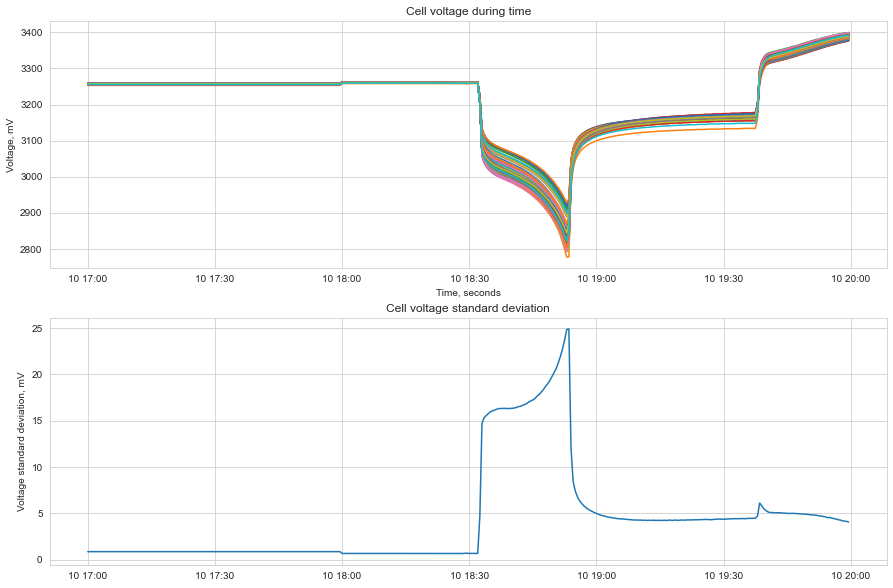

In [37]:
# Lets draw 2 plots: Change of voltage during the time and change of standard deviation between cells during the time.
fig, (top, bottom) = plt.subplots(2,1,figsize = (15, 10))
top.plot(df_30sec)
bottom.plot(np.std(df_30sec, axis = 1))
top.set_title("Cell voltage during time")
top.set_ylabel("Voltage, mV")
top.set_xlabel("Time, seconds")
bottom.set_title("Cell voltage standard deviation")
bottom.set_ylabel("Voltage standard deviation, mV")
plt.show()

As we can see, the standard deviation increases during charge and discharge with biggest difference at the end of discharge.

This is the moment where most cells tend to fail.

##### We are focused on identifing anomalies when cell voltage exceed 3 standard deviations (probability 0.03% from Normal distribution)

##### Sensor precision:
http://www.bmser.com/?_l=en

Based on information from website:

"24 Road monomer voltage acquisition (precision <5mV) "

##### As we can see during some period of time our standard deviation is within 1mV range, but we will use 5mV as a minimum threshold during oprations, because this is the precision of voltage sensors. 

### Model preparation

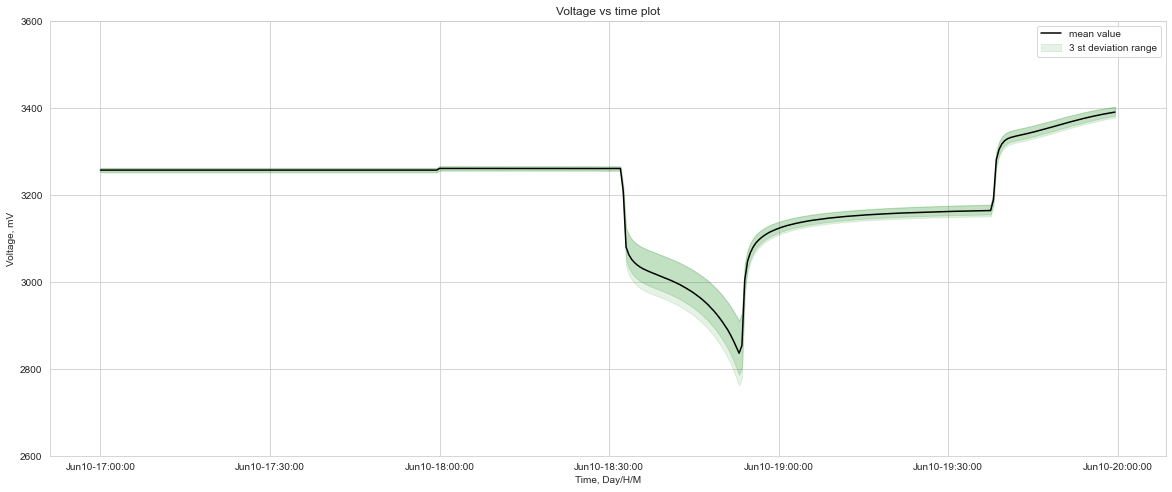

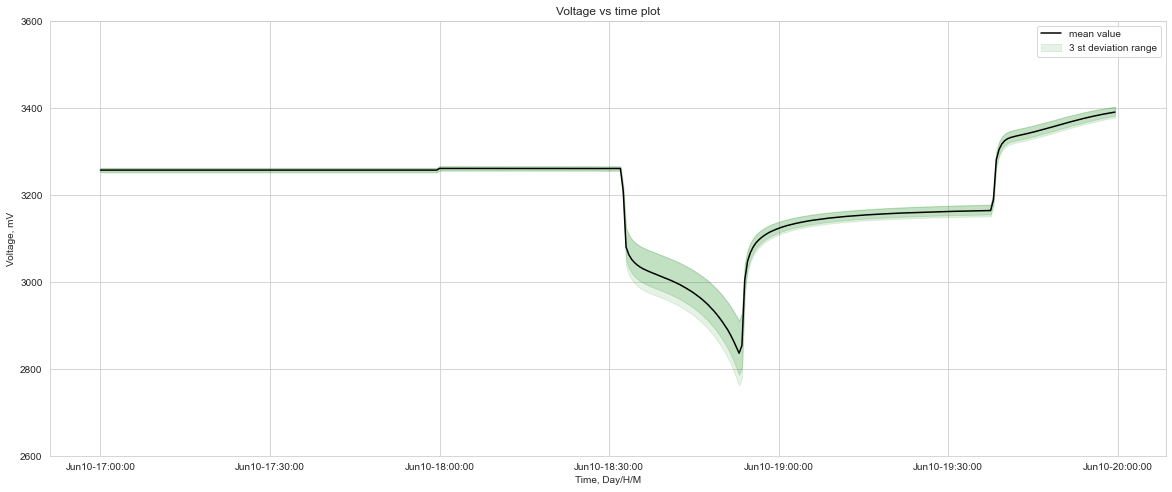

In [38]:
# Create list of thresholds for each point of time
thresholds = create_thresholds(df_30sec)

# show decision boundaries
show_boundaries(df_30sec, thresholds)


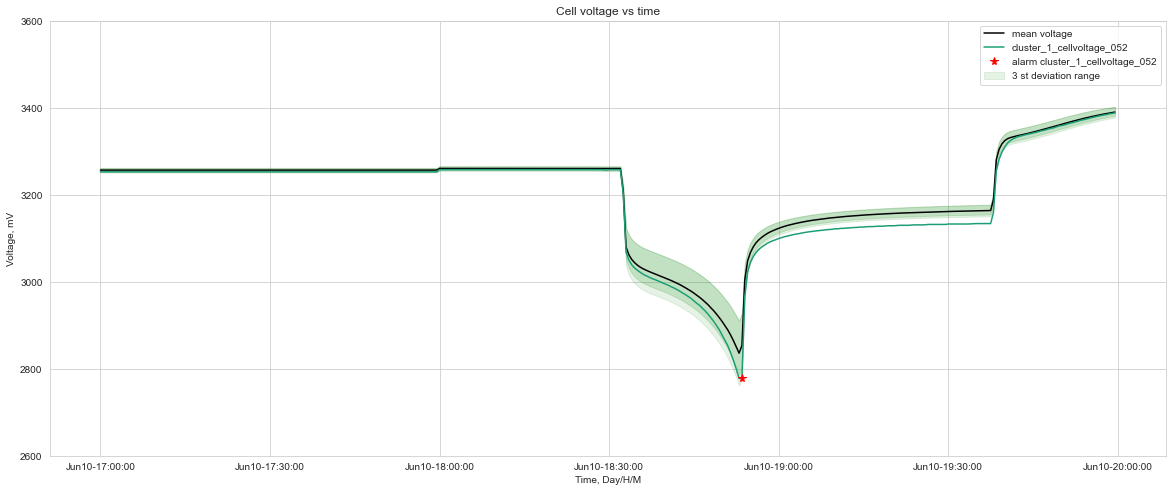

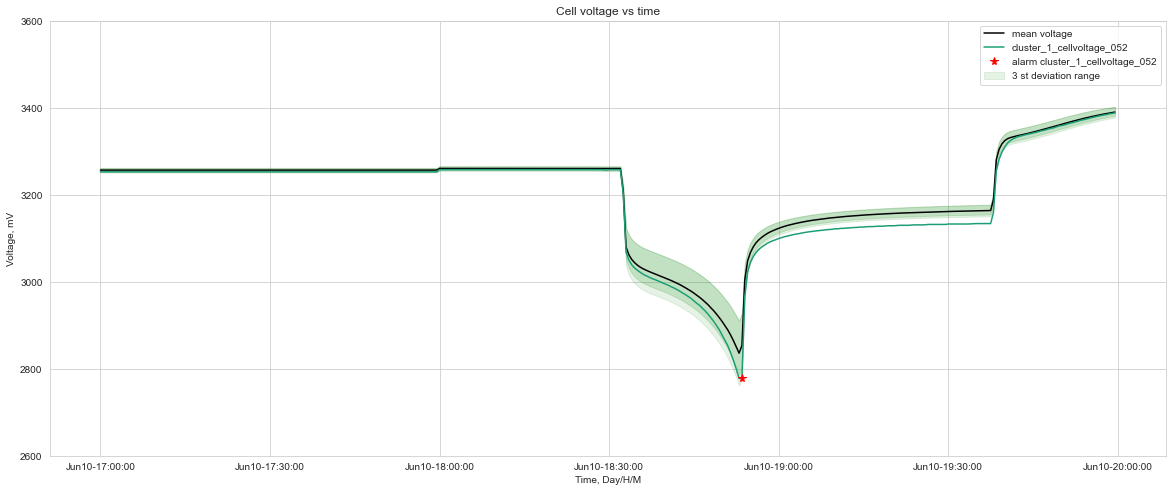

In [39]:
# Find list of faulty sensors
sensor_anomaly_names, sensors = find_anomaly(df_30sec, thresholds, df_30sec_cur)

# Visualize sensors
show_sensors(df_30sec, sensors)

### Temperature distribution

Value mean : 0.23 V
Value standard deviation : 0.0093 V


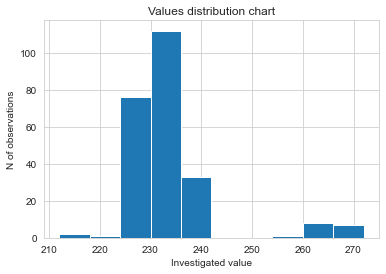

In [40]:
# Explore data distribution
# Idle
#df_30sec_temp.loc["2021-06-10 17:40:00",:].hist()
moment = '2021-06-10 18:53:00'
check_distribution(df_30sec_temp, moment)

Value mean : 17.39 C
Value standard deviation : 1.6194 C


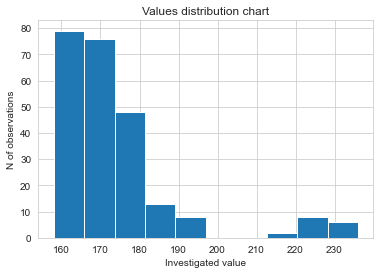

In [41]:
# Lets check voltage sensor reading distribution during different moments of time.
# idle
moment = '2021-06-10 18:00:00'
check_distribution(df_30sec_temp, moment, "temp")

Value mean : 17.4 C
Value standard deviation : 1.5256 C


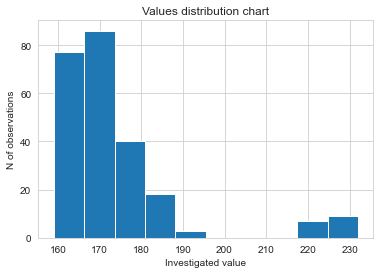

In [42]:
# Resting
moment = '2021-06-10 18:30:00'
check_distribution(df_30sec_temp, moment, "temp")

Value mean : 25.33 C
Value standard deviation : 0.706 C


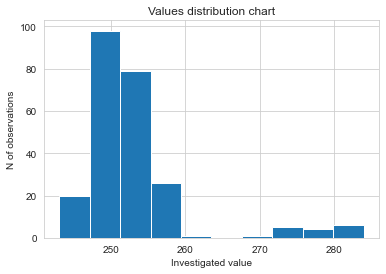

In [43]:
# Charging
moment = '2021-06-10 19:30:00'
check_distribution(df_30sec_temp, moment, "temp")


Value mean : 17.62 C
Value standard deviation : 1.367 C


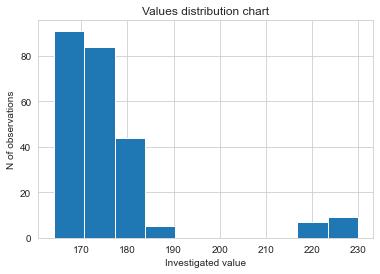

In [44]:
# Start of discharge
moment = '2021-06-10 18:35:00'
check_distribution(df_30sec_temp, moment, "temp")


Value mean : 20.09 C
Value standard deviation : 1.16 C


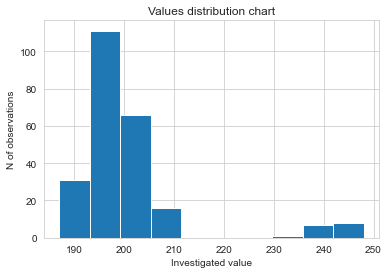

In [45]:
# Middle of discharge
moment = '2021-06-10 18:45:00'
check_distribution(df_30sec_temp, moment, "temp")


In [46]:
# Lets find end of discharge point
timestamp_eod = [key for key, value in df_30sec.min(axis=1).items() if value == df_30sec.min(axis=1).min() ]
timestamp_eod

[Timestamp('2021-06-10 18:53:00', freq='30S')]

Value mean : 23.33 C
Value standard deviation : 0.9309 C


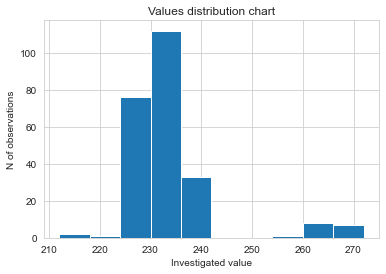

In [47]:
# End of discharge
moment = '2021-06-10 18:53:00'
check_distribution(df_30sec_temp, moment, "temp")


##### We can clearly see "hot regions" that probably formed due to cooled air distribution
##### Batteries recommended temperature should be within 10-40 degrees range. 
##### We cannot make normality assumption 

In [48]:
thresholds_temp = create_thresholds(df_30sec_temp, False)

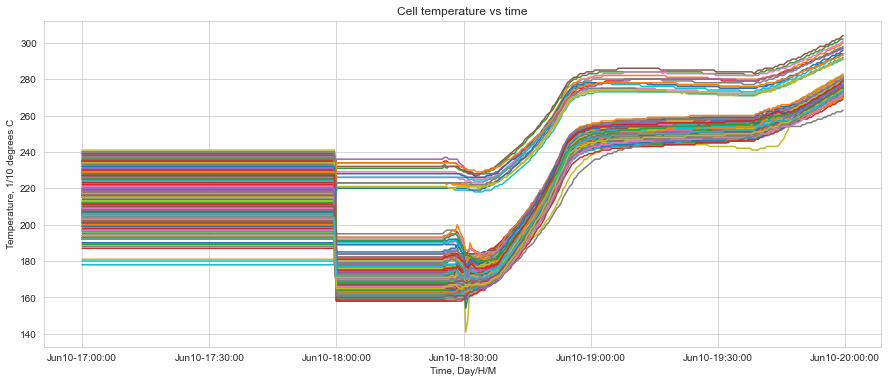

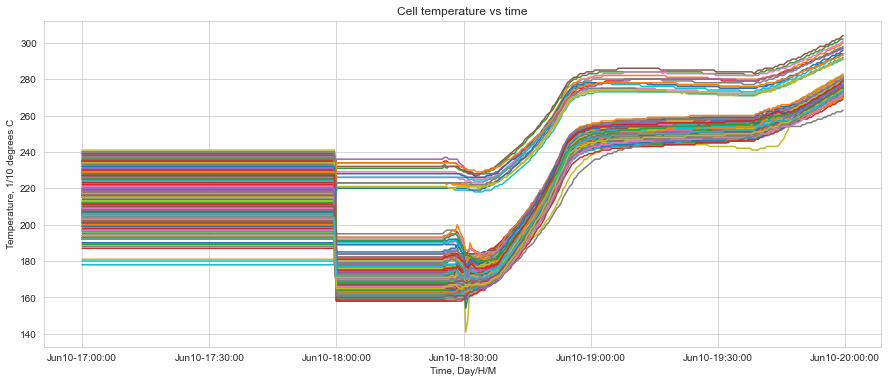

In [49]:
plot_sensors(df_30sec_temp, False)

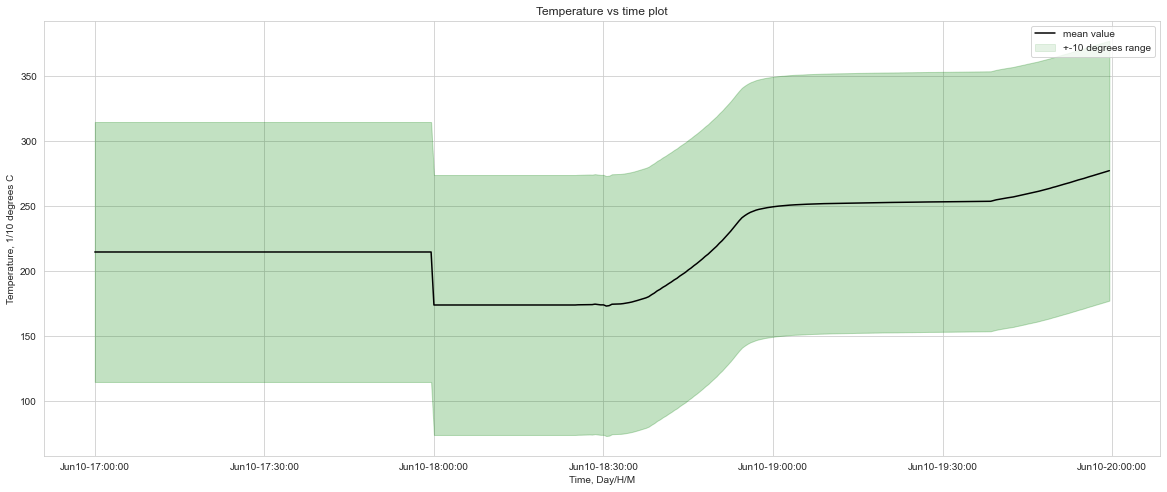

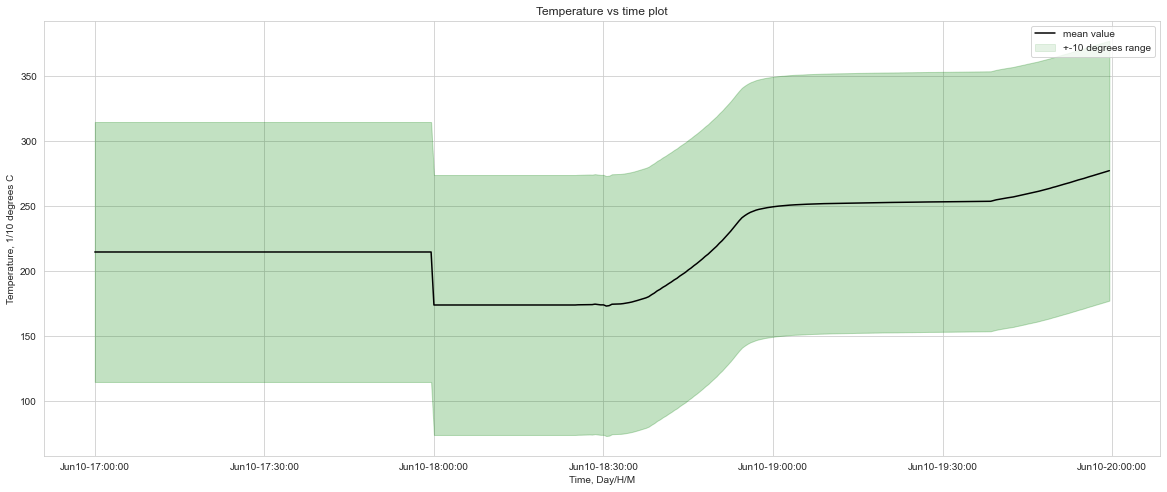

In [50]:
show_boundaries(df_30sec_temp, thresholds_temp, False)

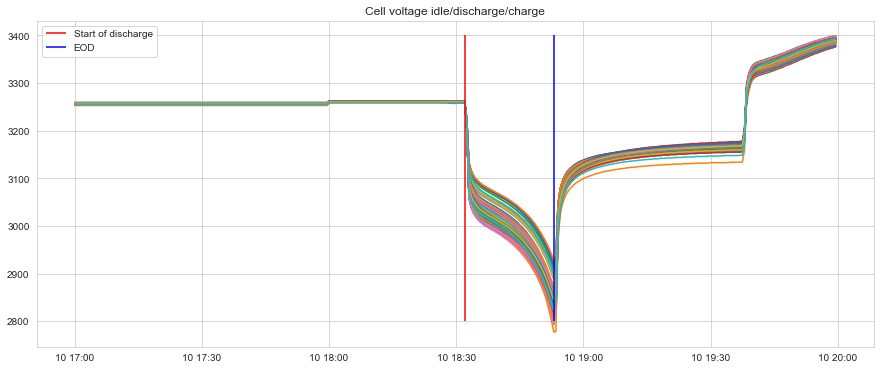

In [51]:
fig, axs = plt.subplots(figsize = (15, 6))
plt.plot(df_30sec)
axs.set_title("Cell voltage idle/discharge/charge")
plt.vlines(x = df_30sec.index[184],ymin = 2800, ymax = 3400, color = "red", label = "Start of discharge")
plt.vlines(x = timestamp_eod,ymin = 2800, ymax = 3400, color = "blue", label = "EOD")
plt.legend()
plt.show()







In [52]:
sensor_anomaly_names, sensors = find_anomaly(df_30sec_temp, thresholds_temp, df_30sec_cur, False)

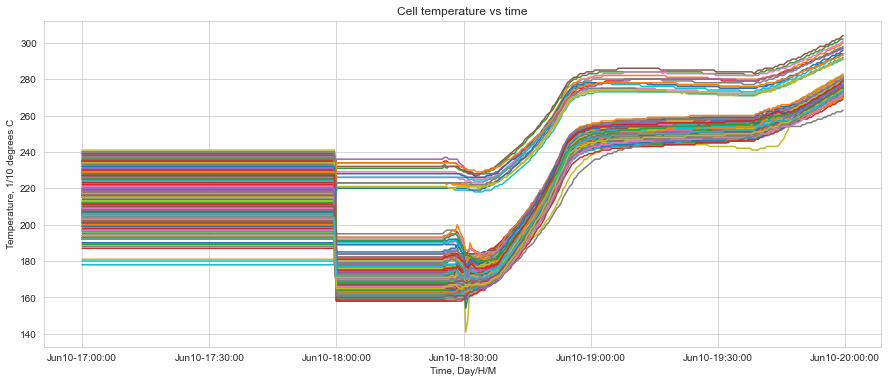

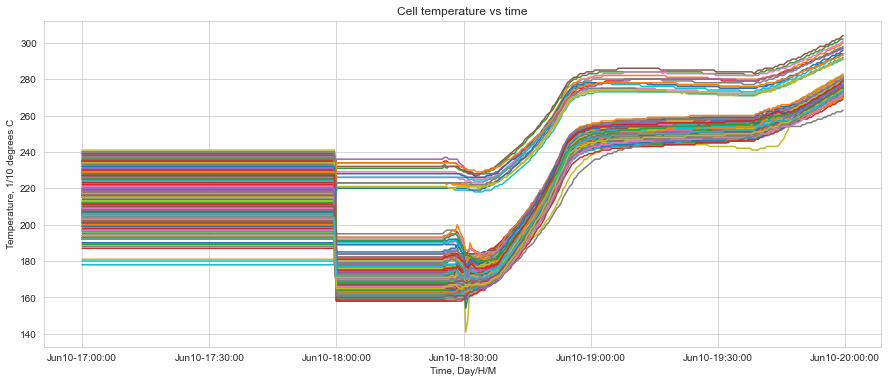

In [53]:
plot_sensors(df_30sec_temp, False)

# Test dataset.

In [54]:
# Choose the folder:
raw_folder = "Test_data/"
result_list = data_preprocess(raw_folder)

Number of Clusters were found: 5


In [55]:
# Check for anomalies
faulty_sensors = analyse_data(result_list)
print_results(faulty_sensors)

cluster N 1, discharge anomaly, cellvoltage sensor N 052
cluster N 2, discharge anomaly, cellvoltage sensor N 104
cluster N 2, discharge anomaly, cellvoltage sensor N 148
cluster N 2, discharge anomaly, cellvoltage sensor N 237
cluster N 3, discharge anomaly, cellvoltage sensor N 024
cluster N 3, discharge anomaly, cellvoltage sensor N 228
cluster N 4, discharge anomaly, cellvoltage sensor N 029
cluster N 4, discharge anomaly, cellvoltage sensor N 050
cluster N 4, discharge anomaly, cellvoltage sensor N 051
cluster N 4, discharge anomaly, cellvoltage sensor N 052
cluster N 4, discharge anomaly, cellvoltage sensor N 053
cluster N 5, discharge anomaly, cellvoltage sensor N 099
cluster N 5, discharge anomaly, cellvoltage sensor N 100
cluster N 5, discharge anomaly, cellvoltage sensor N 116
cluster N 5, discharge anomaly, cellvoltage sensor N 159


### Check decision boundaries for both clusters

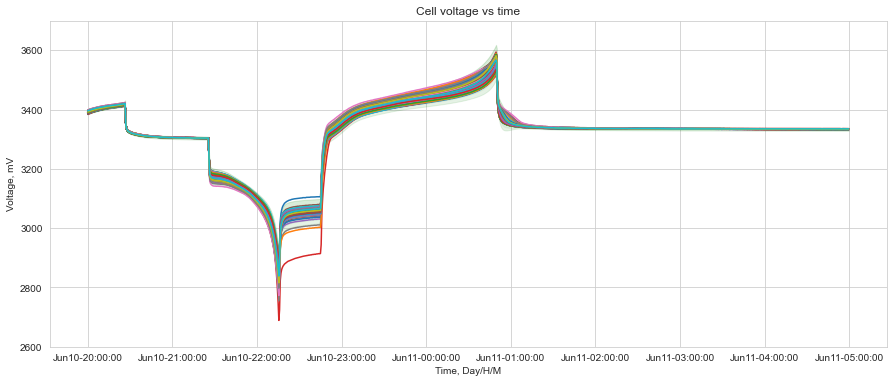

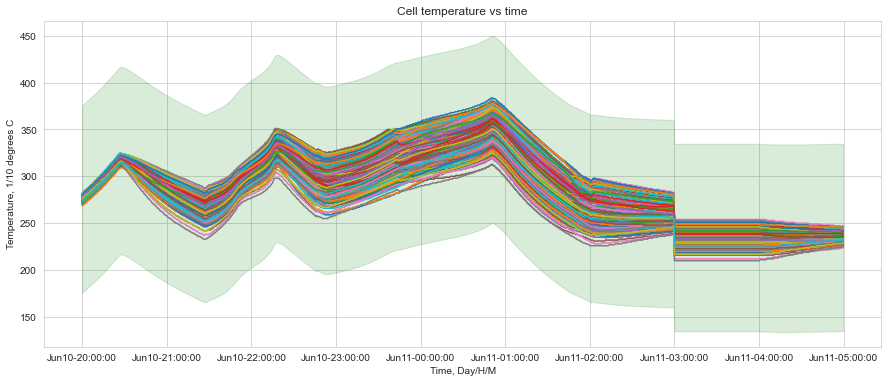

In [56]:
# Plot sensors data(raw)
cluster = 2
plot_cluster_sensors(result_list, cluster, boundaries = True)

### Plot errors in clusters

Cluster N : 4
The number of sensors with voltage anomaly: 5
The number of sensors with temperature anomaly: 0


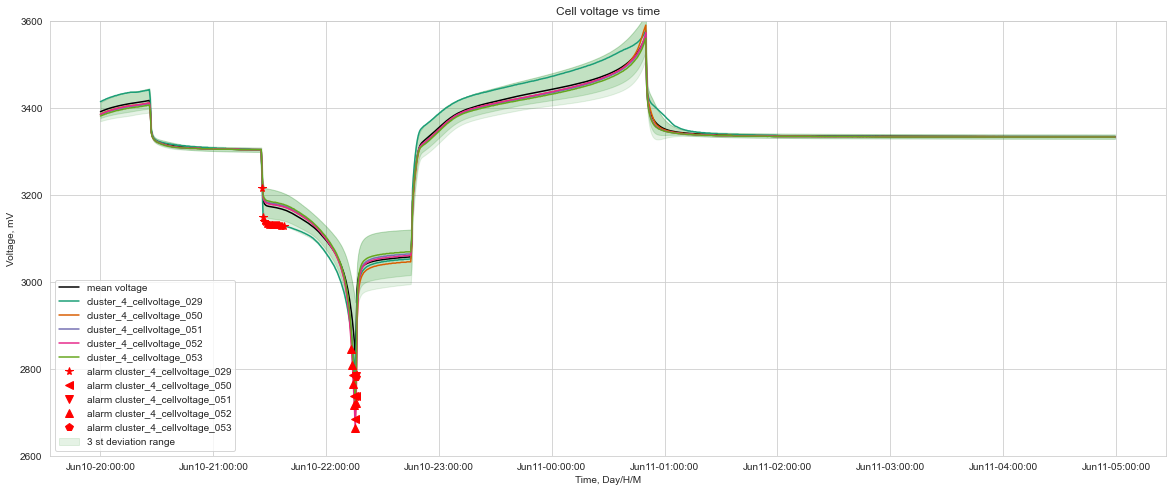

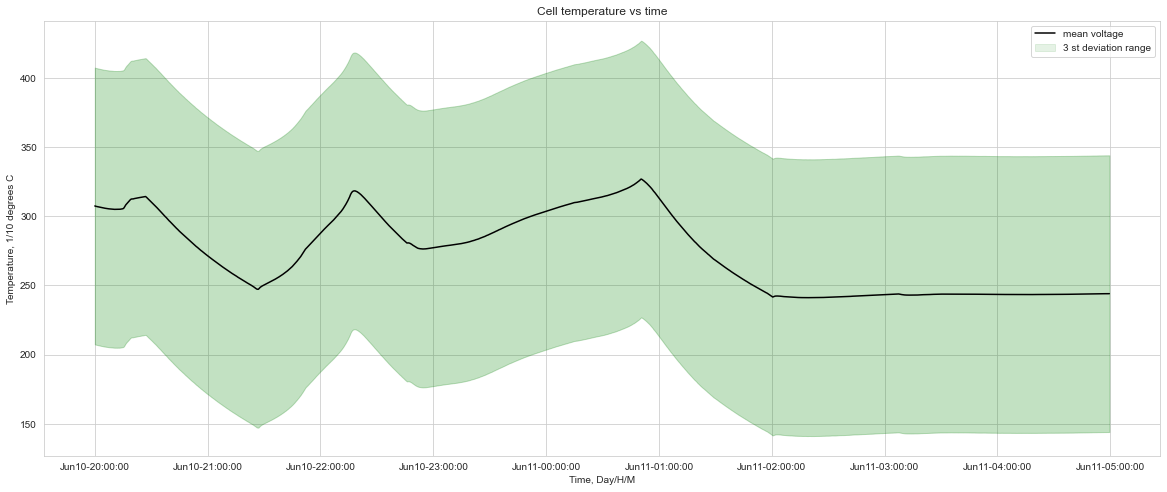

In [57]:
cluster = 4
plot_cluster_anomalies(result_list, faulty_sensors, cluster)

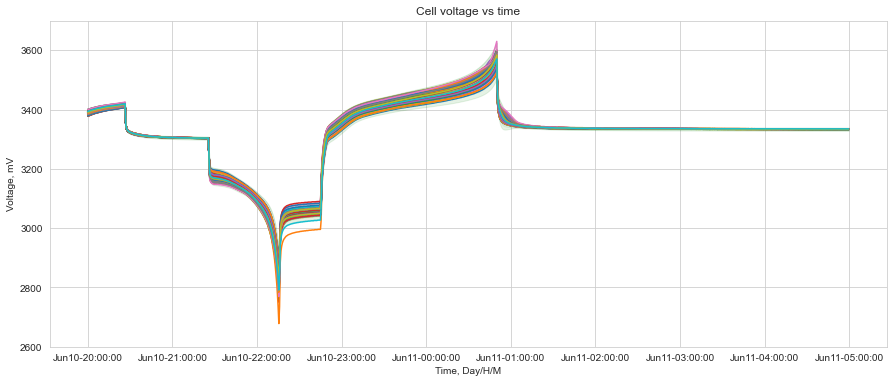

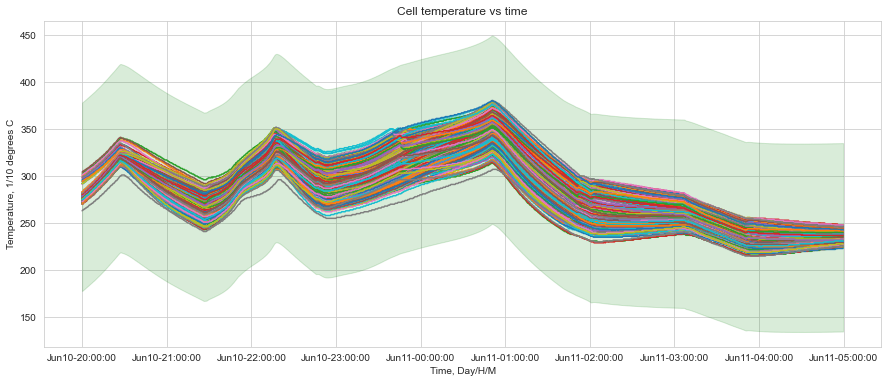

Cluster N : 1
The number of sensors with voltage anomaly: 1
The number of sensors with temperature anomaly: 0


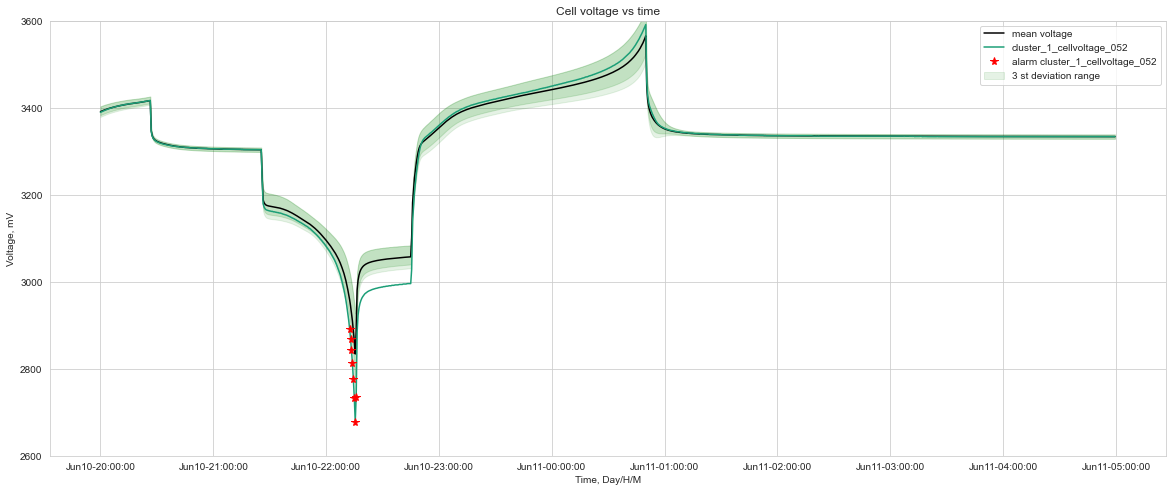

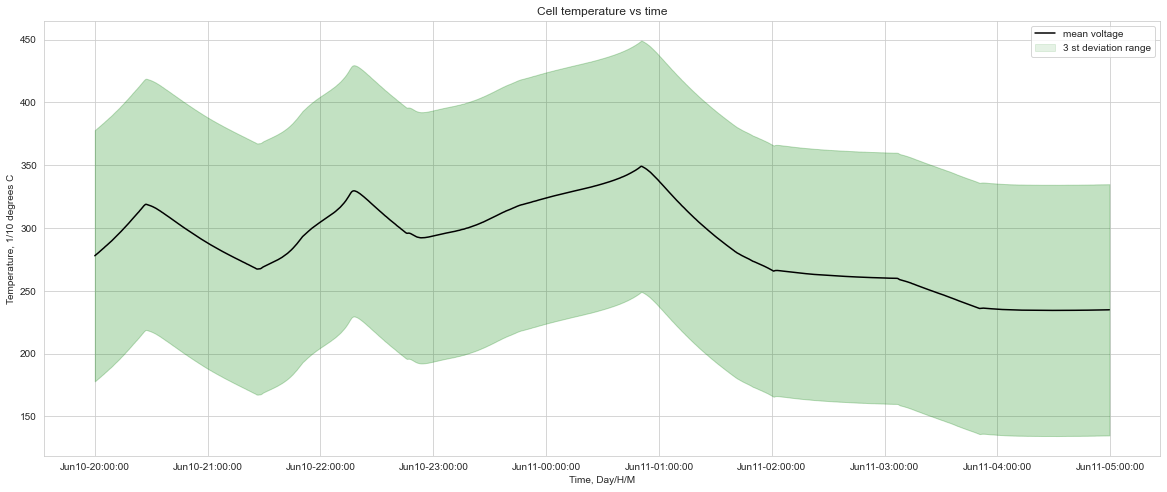

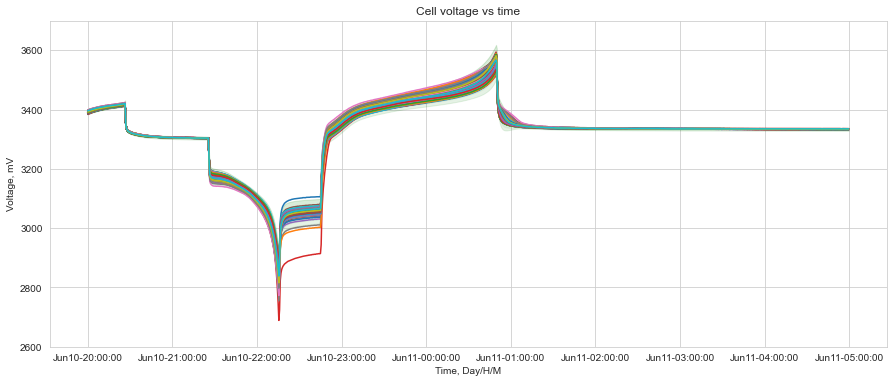

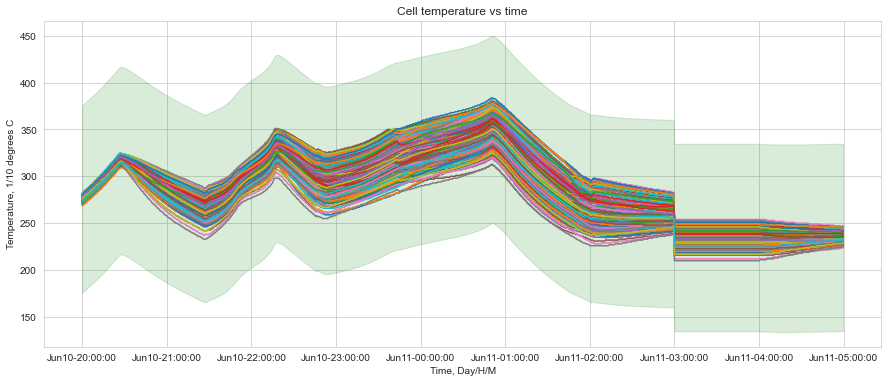

Cluster N : 2
The number of sensors with voltage anomaly: 3
The number of sensors with temperature anomaly: 0


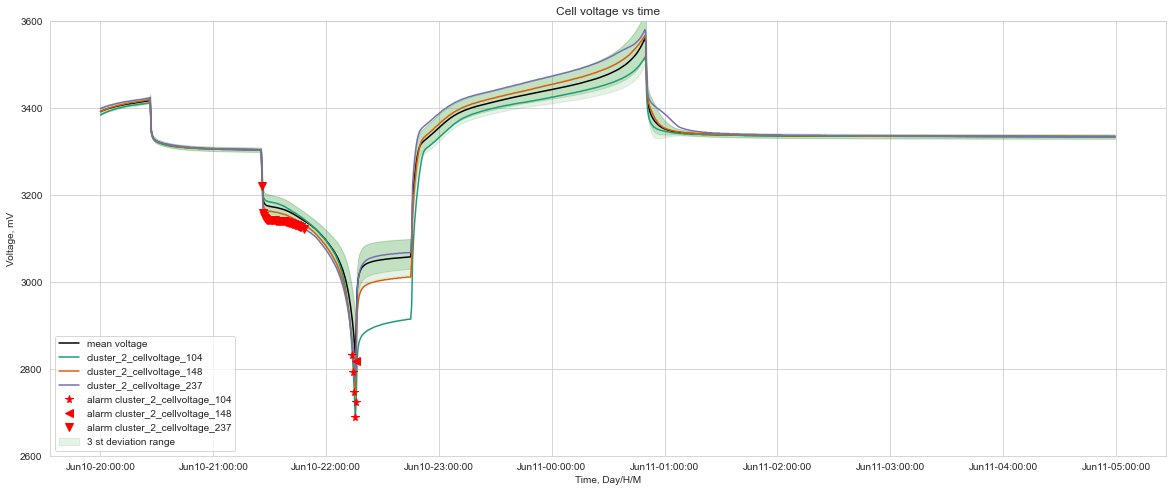

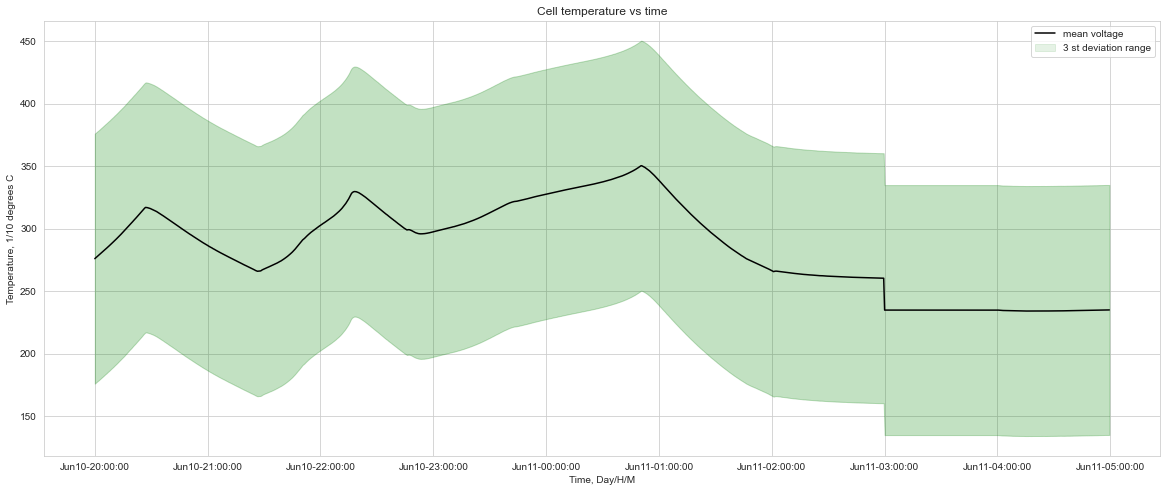

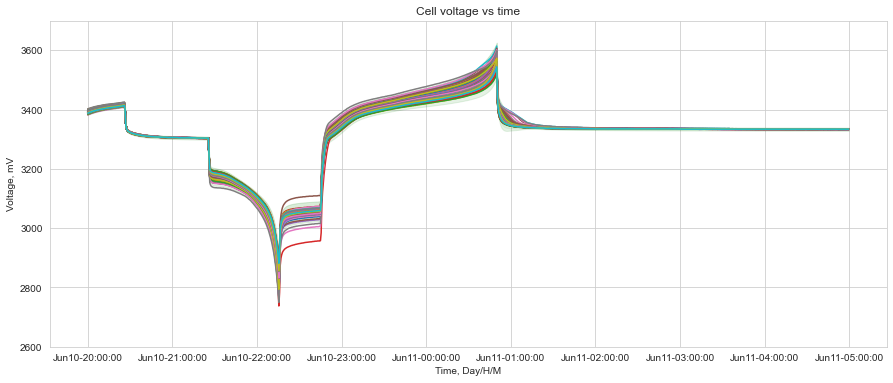

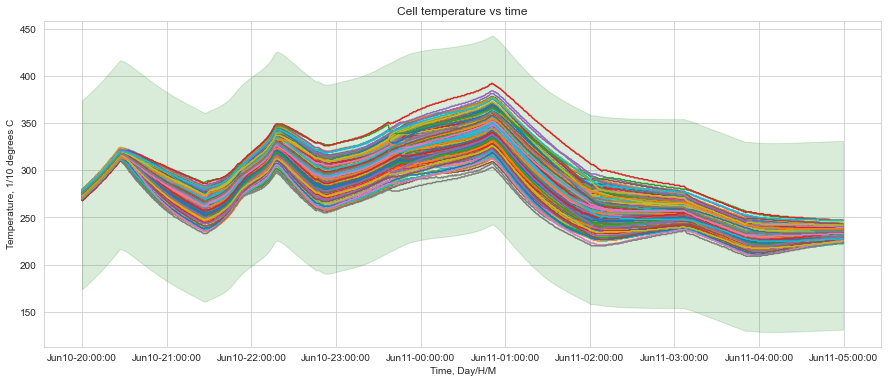

Cluster N : 3
The number of sensors with voltage anomaly: 2
The number of sensors with temperature anomaly: 0


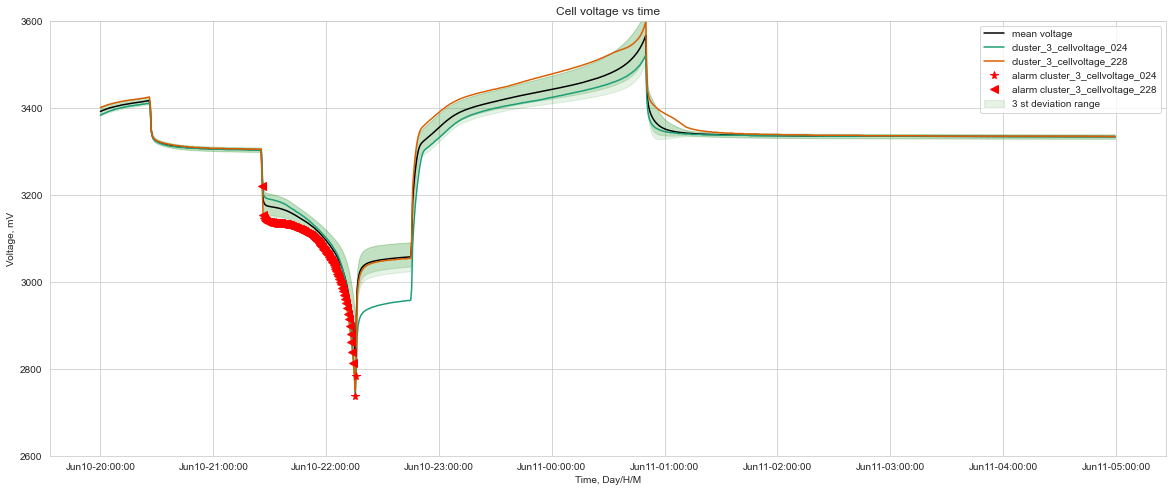

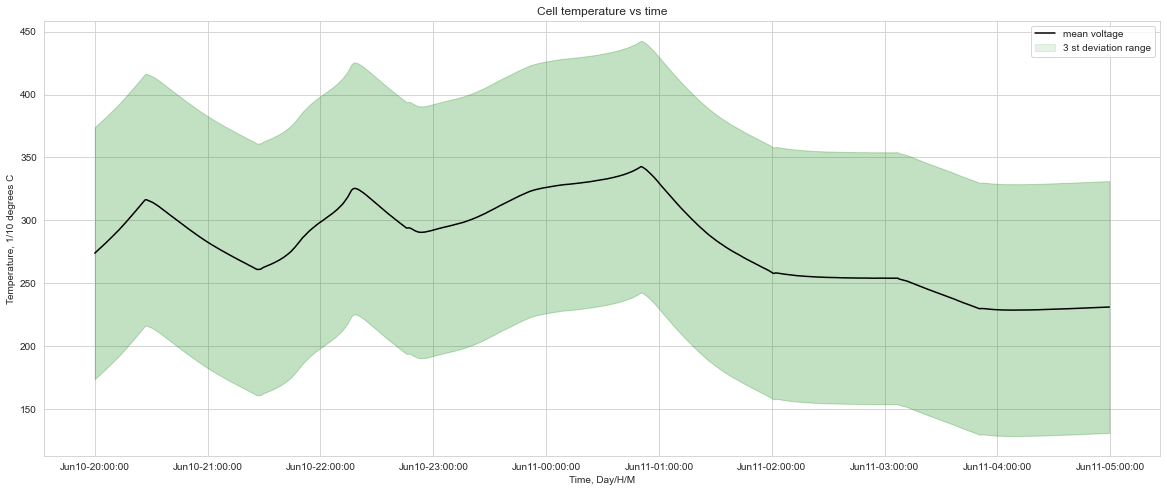

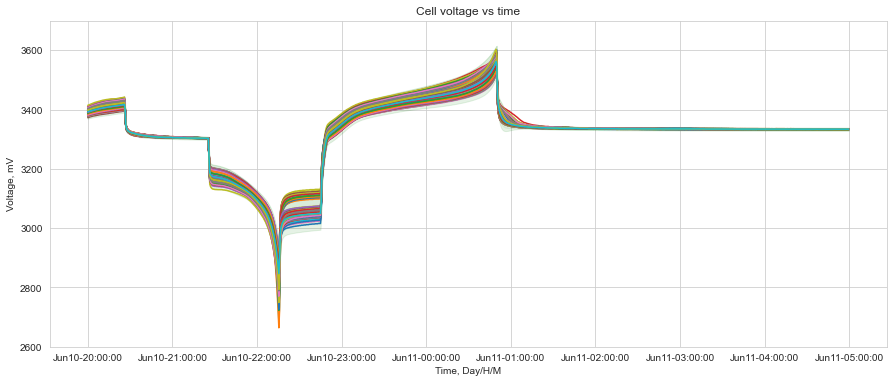

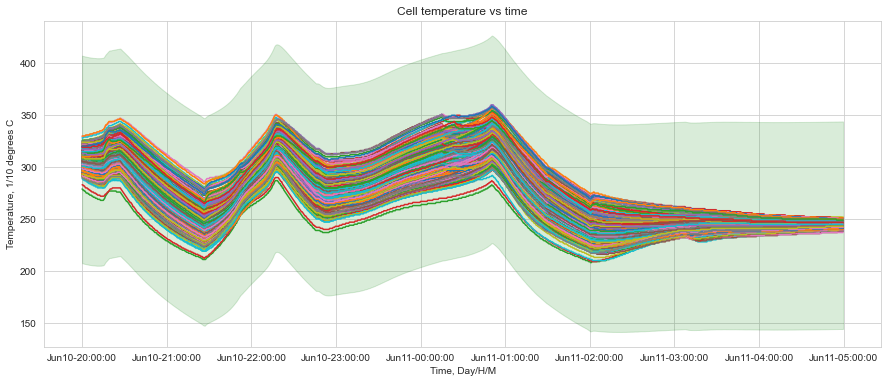

Cluster N : 4
The number of sensors with voltage anomaly: 5
The number of sensors with temperature anomaly: 0


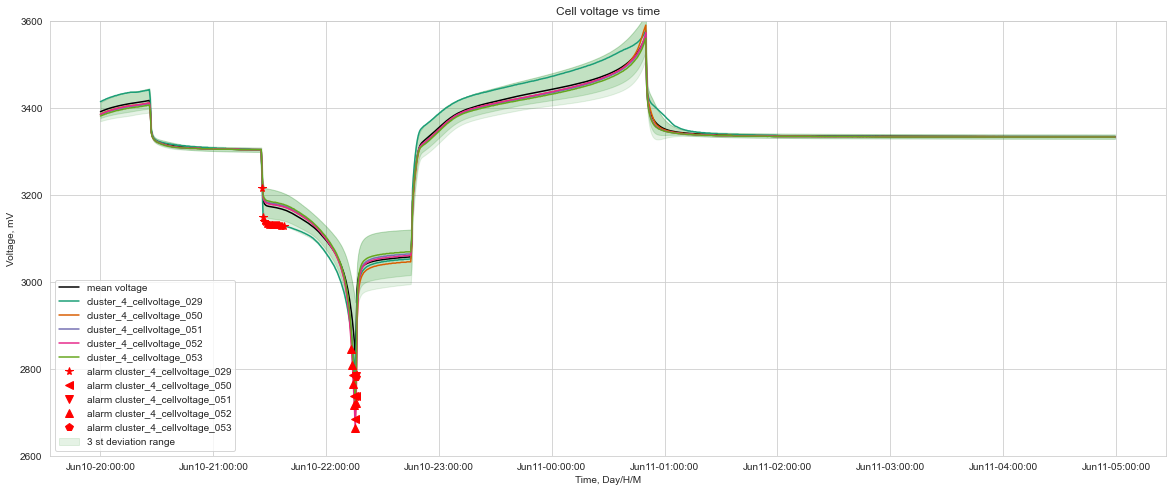

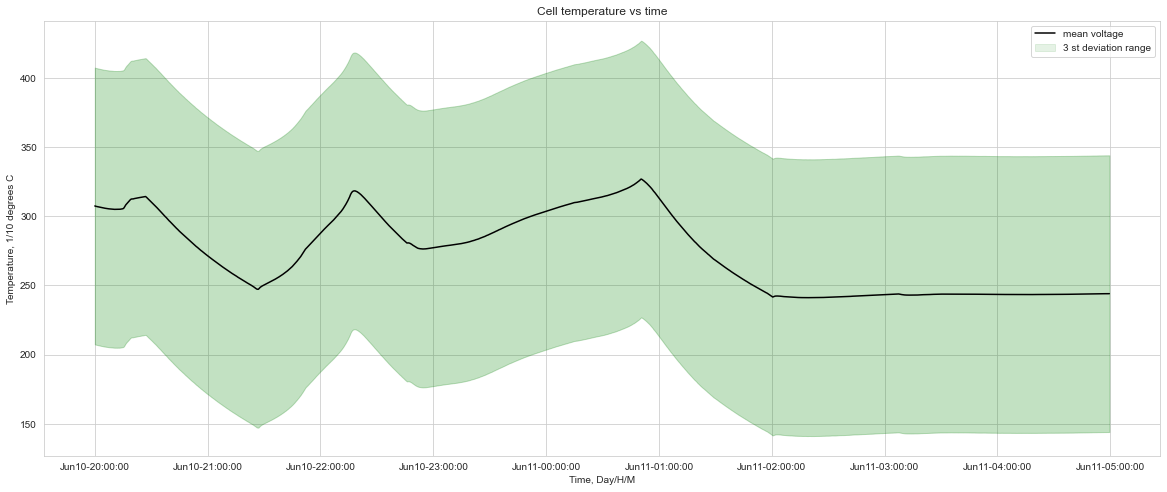

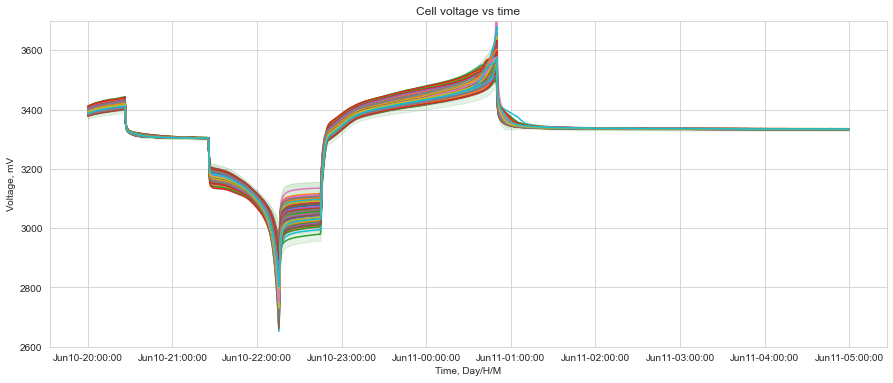

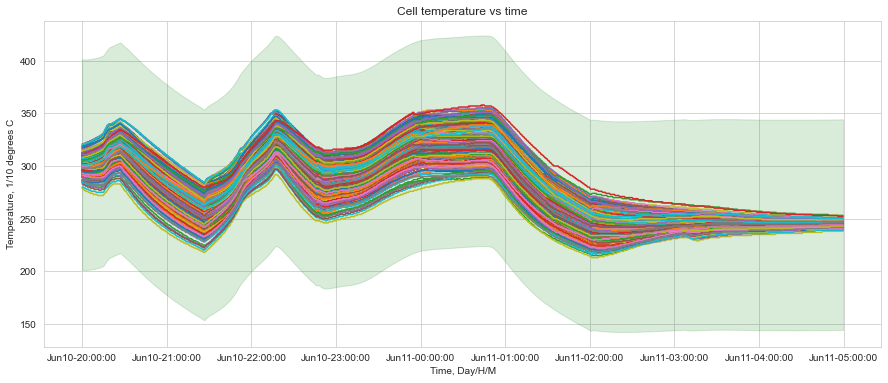

Cluster N : 5
The number of sensors with voltage anomaly: 4
The number of sensors with temperature anomaly: 0


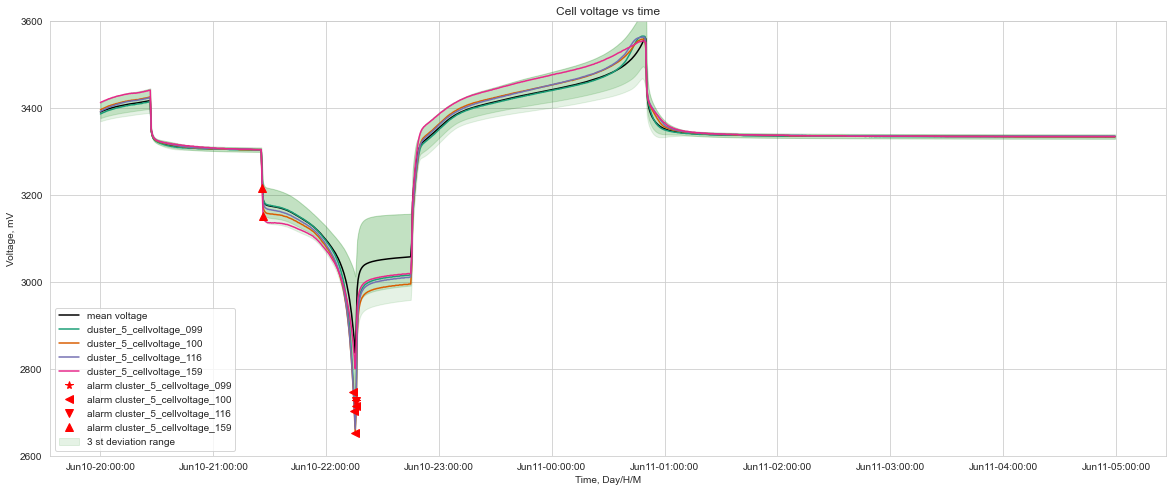

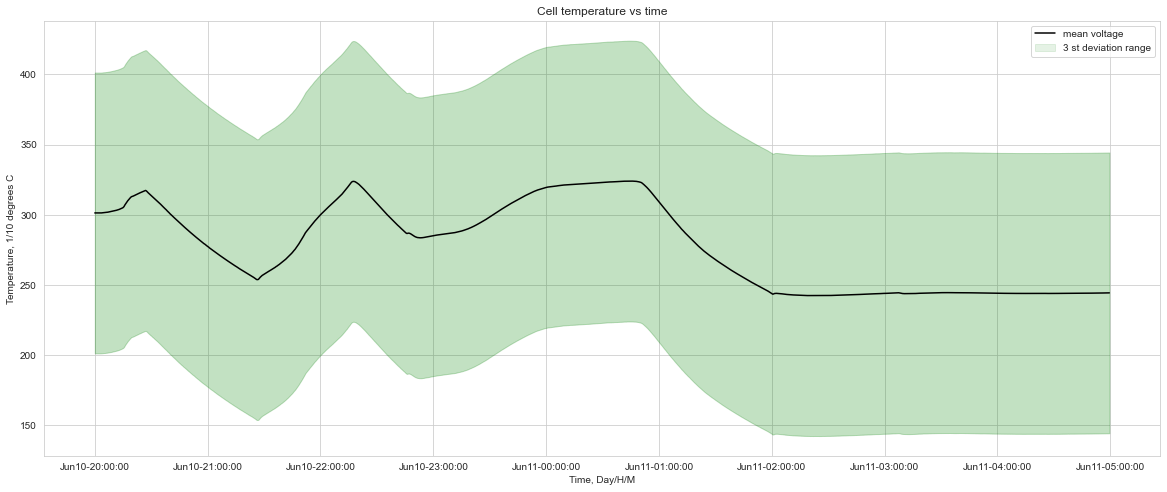

In [66]:
get_all_results(result_list, faulty_sensors)

In [68]:
create_report(faulty_sensors)

In [70]:
document = Document()
heading = "Report:" + str(conf.clusters)+ " cluster system report." + " \n Time: " + datetime.now().strftime("%D - %H:%M")
document.add_heading(heading, 0)
p = document.add_paragraph('This system consist of ')
p.add_run(str(cluster)).bold = True
p.add_run(' clusters.')
p = document.add_paragraph('Total number of anomalies ')
p.add_run(str(len(faulty_sensors))).bold = True
p.add_run(' .')
document.add_heading('Error overview:', level=1)
table = document.add_table(rows=1, cols=5)
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Cluster N'
hdr_cells[1].text = 'Sensor N'
hdr_cells[2].text = 'Alarm type'
hdr_cells[3].text = 'Error begin time:'
hdr_cells[4].text = 'Error end time:'
for sensor in faulty_sensors:
        row_cells = table.add_row().cells
        row_cells[0].text = re.search('cluster_([0-9]+)_', sensor[1]).group(1)
        row_cells[1].text = re.search('cluster_.+_[A-Za-z_]+_([0-9]+)$', sensor[1]).group(1)
        row_cells[2].text = sensor[2]
        row_cells[3].text = str(sensor[0].index[0])
        row_cells[4].text = str(sensor[0].index[-1])
document.add_page_break()
files = [conf.report_path + file for file in os.listdir(conf.report_path) if (file.endswith("png")) and (file.startswith("Cluster"))]
for i in list(range(conf.clusters)):
        i = i + 1
        heading = 'Error overview: '  + "Cluster " + str(i) + " ."
        document.add_heading(heading, level=1)
        p = document.add_paragraph('This cluster has: ')
        p.add_run(str(len([sensor for sensor in faulty_sensors if 
                     (re.search('cluster_([0-9]+)_', sensor[1]).group(1) == str(i)) and
                     sensor[2] == 'discharge anomaly']))).bold = True
        p.add_run( " voltage anomalies.\n")
        p = document.add_paragraph('This cluster has: ')
        p.add_run(str(len([sensor for sensor in faulty_sensors if 
                     (re.search('cluster_([0-9]+)_', sensor[1]).group(1) == str(i)) and
                     sensor[2] == "temperature anomaly"]))).bold = True
        p.add_run( " temperature anomalies.\n")
        heading = 'Voltage and Temperature plots over time'
        document.add_heading(heading, level=2)
        document.add_paragraph('Voltage sensor readings: ')
        for file in files:
            if str(i) in file and "voltage sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass
        document.add_paragraph('Temperature sensor readings: ')
        for file in files:
            if str(i) in file and "temperature sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass
        document.add_page_break()
        heading = "Voltage and Temperature anomalies plots over time"
        document.add_heading(heading, level=2)
        document.add_paragraph('Voltage anomalies: ')
        for file in files:
            if str(i) in file and "voltage anomaly sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass         
        document.add_paragraph('Temperature sensor readings: ')
        for file in files:
            if str(i) in file and "temperature anomaly sensors" in file:
                document.add_picture(file, width=Inches(7.0))
            else:
                pass
        document.add_page_break()
document.save('report/report_file2.docx')

In [98]:
from docx.enum.section import WD_ORIENT


In [99]:
document = Document()
heading = "Report:" + str(conf.clusters)+ " cluster system report." + " \n Time: " + datetime.now().strftime("%D - %H:%M")
document.add_heading(heading, 0)
p = document.add_paragraph('This system consist of ')
p.add_run(str(cluster)).bold = True
p.add_run(' clusters.')
p = document.add_paragraph('Total number of anomalies ')
p.add_run(str(len(faulty_sensors))).bold = True
p.add_run(' .')
document.add_heading('Error overview:', level=1)
table = document.add_table(rows=1, cols=5)
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Cluster N'
hdr_cells[1].text = 'Sensor N'
hdr_cells[2].text = 'Alarm type'
hdr_cells[3].text = 'Error begin time:'
hdr_cells[4].text = 'Error end time:'
for sensor in faulty_sensors:
        row_cells = table.add_row().cells
        row_cells[0].text = re.search('cluster_([0-9]+)_', sensor[1]).group(1)
        row_cells[1].text = re.search('cluster_.+_[A-Za-z_]+_([0-9]+)$', sensor[1]).group(1)
        row_cells[2].text = sensor[2]
        row_cells[3].text = str(sensor[0].index[0])
        row_cells[4].text = str(sensor[0].index[-1])
new_width, new_height = section.page_height, section.page_width
new_section = document.add_section(2)
new_section.page_width = new_width
new_section.page_height = new_height
new_section.orientation = WD_ORIENT.LANDSCAPE
document.add_page_break()
document.add_paragraph('This system consist of ')

document.save('report/report_file2.docx')

In [87]:
sections = document.sections
sections

len(sections)

section = sections[0]
section
for section in sections:
    print(section.start_type)

NEW_PAGE (2)
NEW_PAGE (2)
EVEN_PAGE (3)
NEW_PAGE (2)
NEW_PAGE (2)
NEW_PAGE (2)


In [83]:
new_section = document.add_section()
new_section.start_type

2

In [86]:
new_section = document.add_section()
new_section

In [ ]:
>>> section.orientation, section.page_width, section.page_height
(PORTRAIT (0), 7772400, 10058400)  # (Inches(8.5), Inches(11))
>>> new_width, new_height = section.page_height, section.page_width
>>> section.orientation = WD_ORIENT.LANDSCAPE
>>> section.page_width = new_width
>>> section.page_height = new_height
>>> section.orientation, section.page_width, section.page_height
(LANDSCAPE (1), 10058400, 7772400)

In [91]:
new_width, new_height = section.page_height, section.page_width

In [90]:
section.orientation = 1

In [94]:
section.page_width = new_width
section.page_height = new_height
section.orientation, section.page_width, section.page_height
section.start_type

2

In [93]:
section.orientation, section.page_width, section.page_height

(1, 10058400, 7772400)

# Conclusion
---
Based on results our finall model will be: "Pre-trained Augmented CNN 224x224 frozen layer MobileNetV2"

With the following parameters after tuning:

Accuracy - 0.9519

Recall - 0.9769

Because of the following reasons: 

1) It satisfy requirements on recall (higher 0.95).

2) It has high accuracy. 

Another solution for this problem might be identify cases that has probability between classes and send it to firther investigation by takeholder.
We are interested in maximizing racall (min FN) so we will remove prediction not equally from decision boundary, but we will drop cases with probabiblity 0.25-0.55 
This approach allows us to get accuracy 0.9726 and recall 0.992

Overall, this data tells us that current X-ray have enought information so we can be sure that each patient will be treated well. 